# Behavioral Cloning for Cuphead via Autoencoder-Recurrent Networks

# Table of Contents
  - [**1. Introduction and Summary of the Findings**](#1-introduction-and-summary-of-the-findings)
  - [**2. Data Collection and Pre-processing**](#2-data-collection-and-pre-processing)
  - [**3. Mathematical Underpinnings and Model Architecture**](#3-mathematical-underpinnings-and-model-architecture)
  - [**4. Results and Discussion**](#4-results-and-discussion)
  - [References](#references)
  - [Appendix A: Model Training Code](#appendix-a-model-training-code)
  - [Appendix B: EDA](#appendix-b-eda)
  - [Appendix C: Custom Session Recorder Code](#appendix-c-custom-session-recorder-code)


## 1. **Introduction and Summary of the Findings**

### **1.1 Project Objective**
Building on previous work classifying boss fights based on keystroke patterns, this project pivots to a more ambitious goal: Behavioral Cloning. The objective is to train an autonomous agent to play Cuphead by imitating human gameplay.

I selected The Root Pack (Botanic Panic) boss fight for this experiment, as its distinct projectiles and stationary enemies provide an ideal environment for testing spatial reasoning and reaction times.

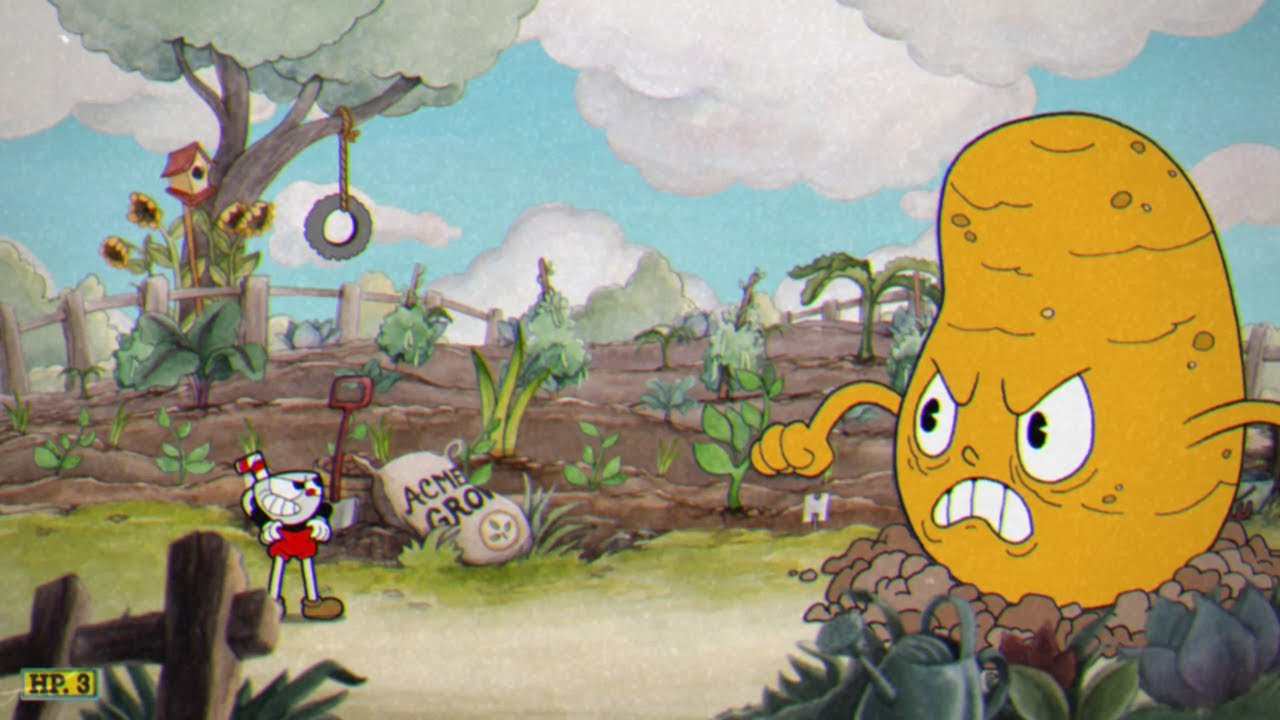

The core challenge was that the agent must learn to extract spatial features (e.g., where the projectile is) and infer temporal dynamics (velocity and trajectory) solely from a sequence of grayscale images, without access to internal game variables.

### **1.2 Core Problem**

Before training, I analyzed the distribution of actions in the dataset (see Appendix B for the code). This revealed a critical obstacle: Extreme Class Imbalance.

In Cuphead, the player holds the 'Shoot' button almost constantly, while special keys like 'Jump' and 'Dash' are executed only in split-second reaction to threats. As shown in Figure 1, the 'Shoot' action is active in 55.8% of frames, while 'Jump' appears in only 2.9% and 'Dash' in 0.7%.

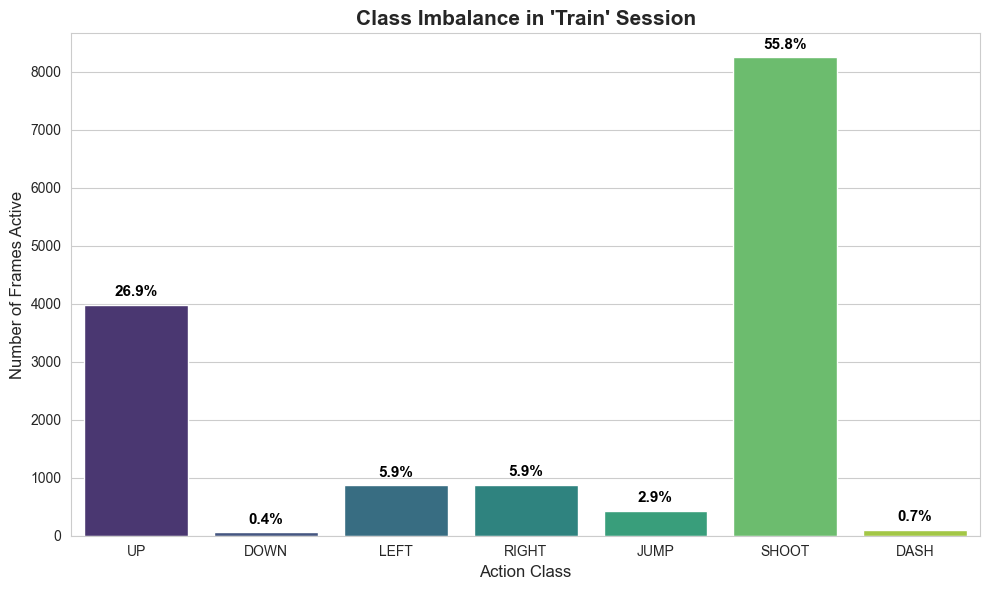

*Figure 1: Distribution of active frames per action class in the training session.*

Due to this distribution, a standard model optimizing for global accuracy can achieve $\approx 96\%$ accuracy simply by predicting "Shoot" constantly and never "Jumping." (see Appendix A's AE + LSTM model)

### **1.3 Methodology and Experimental Design**
To overcome this, I designed an experiment to evaluate the trade-offs between Latent Space size and RNN Cell type.

1. **Data Acquisition:** Utilized a custom **Session Recorder** (Appendix C) to gather a dataset of 15 sessions for training and 1 held-out test session.
2. **Vision Layer:** An **Autoencoder** compresses raw frames ($128 \times 72$) into different sizes of Latent Vectors.
3. **Decision Layer:** Comparing **LSTM** (Long Short-Term Memory) vs. **GRU** (Gated Recurrent Unit)
*   Additionally, I Implemented **Sigmoid Focal Loss** to penalize the model heavily for missing rare events, forcing it to learn those events.

### **1.4 Key Findings**

1. The initial model (trained with standard Cross-Entropy) converged to a trivial solution—constantly shooting and never jumping or moving left/right—achieving high accuracy but 0% utility. Introducing Focal Loss ($\gamma=2.0$) immediately recovered reflexive behaviors, raising the Jump Recall from 0.00 to over 0.60.
2.  Performance did not scale linearly with model size. A latent dimension of **128** proved too compressed, blurring small projectiles and causing the agent to run into damage. Conversely, a dimension of **1024** led to overfitting. A latent size of **512 dimensions** balanced detail retention with generalization.
3.  The best model (GRU-512) achieved a **Composite F1-Score of 0.67**, successfully chaining jumps, dashes and arrow keys that the initial model completely ignored.

## **2. Data Collection and Pre-processing**

### **2.1 Data Collection**

#### Full code and code explanation in **Appendix C**

To capture this data, the recorder generates three distinct files for every session:
1.  **Video (`.mp4`):** The visual gameplay recorded at 10 FPS.
2.  **Event Log (`_events.jsonl`):** A stream of keystrokes (`keydown`/`keyup`), each tagged with a UTC timestamp.
3.  **Frame Log (`_frames.jsonl`):** This file records the UTC timestamp for every specific frame index in the `.mp4` file, which helps map visual states to log events with millisecond accuracy.

### Main Challenge for Recordings (Variable Frame Rate Drift)

A critical engineering challenge in screen recording for imitation learning is **Variable Frame Rate Drift**. Standard recording loops utilizing `time.sleep()` accumulate execution latency (e.g., OS hangs during heavy gameplay). Over a 15-minute session, this causes the video duration to shrink relative to the time of the keystroke logs, misaligning labels.

To resolve this, I synchronized the session recorder with UTC time. Instead of relying on relative sleep times, the recorder enforces a forced constant frame rate. The worker thread calculates exactly when the next frame should exist ($t_{next}$). If the system lags and $t_{now} > t_{next}$, the recorder duplicates the current frame to fill the missing time slots, ensuring the video file stays aligned with the UTC timestamps of the input logs.

### **2.2 Data Loading and Visual Transformation**
#### [GitHub - Training + Test Data (`.jsonl` logs)](https://github.com/ddanakim0304/CS156-Assignment-2/tree/main/data/sessions)

The raw input ($1280 \times 720$ RGB) is too high-dimensional for efficient training. The preprocessing pipeline transforms this into a tensor format suitable for the Autoencoder.

**Transformation Pipeline:**
1.  **Grayscale Conversion:** Reduces tensor depth ($3 \to 1$). Color is redundant for *Cuphead* mechanics (projectiles are distinct by shape/contrast).
2.  **Resizing:** Downsamples resolution to $128 \times 72$ to reduce dimensionality while preserving projectile visibility.
3.  **Normalization:** Scales pixel intensity from $[0, 255]$ to $[0, 1]$ for neural network stability.

**Code Snippet from model training code (Appendix A)**
```python
# Filter frames outside fight markers to reduce noise
if any(start <= t <= end for start, end in intervals):
    # Preprocessing: Resize -> Grayscale -> Normalize
    frame = cv2.resize(frame, (IMG_WIDTH, IMG_HEIGHT))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).astype('float32') / 255.0
    X_buffer.append(np.expand_dims(frame, axis=-1))
```

**Output Shape:**
After processing 15 training sessions (9,549 frames) and 1 held-out test session (590 frames), the full dataset contains 10,139 frames.
```python
# Output from Data Loader (Appendix A)
Dataset Loaded. Train: (9549, 72, 128, 1)
Dataset Loaded. Val:   (590, 72, 128, 1)
```

### **2.3 Sequence Generation (Sliding Window)**
To allow the Recurrent Neural Network (RNN) to infer velocity and trajectory, individual frames must be structured into temporal sequences. I utilized a sliding window approach:

*   **Sequence Length ($T$):** 10 frames (1.0 second of context).
*   **Stride:** 1 frame.

For a given frame $f_t$, the model receives input vector $X_t = [f_{t-9}, f_{t-8}, ..., f_t]$.

(Further explanation in section 3.2)

### **2.4 Data Splitting Strategy**
I used session-based splitting rather than random shuffling. Random shuffling would leak information by placing adjacent frames (e.g., Frame 100 in Train, Frame 101 in Test) in different sets, allowing the model to "cheat" via interpolation.

*   **Training Set:** 15 mixed win/loss sessions (approx. 15 mins of gameplay).
*   **Validation Set:** 1 specific "Test Session". This session was recorded separately to capture a "Perfect Run" with minimized human error, providing a clean benchmark for evaluation.

## **3. Mathematical Underpinnings and Model Architecture**

The agent must solve two distinct mathematical problems: **State Abstraction** (What is on the screen?) and **Trajectory Inference** (Where is it going?). Finally, the optimization process must address the extreme class imbalance identified in EDA.

### **3.1 The Vision Layer - Autoencoder**
**The Problem**

The raw input $x_t$ is a $128 \times 72$ grayscale image. Treating this as a flat vector of 9,216 features is inefficient because it ignores the spatial topology of the game (e.g., that the pixels forming a "projectile" are clustered together).

**The Solution**

I implemented an **Autoencoder with convolutional layers** to map the high-dimensional raw frame $x_t$ to a low-dimensional latent vector $z_t \in \mathbb{R}^{512}$.
$$ z_t = E_\phi(x_t) $$

Here, $E_\phi$ represents the Encoder network. As shown in the code below, I use **MaxPooling** to progressively downsample the spatial dimensions while increasing the depth (feature channels). This forces the latent vector $z_t$ to discard high-frequency noise (like background stars) and retain only the semantic "Game State"—specifically, the coordinates of the player and the enemies.

**Implementation**

```python
def build_advanced_ae(latent_dim):
    inp = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(inp)
    x = layers.MaxPool2D(2, padding='same')(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.MaxPool2D(2, padding='same')(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.MaxPool2D(2, padding='same')(x)

    flat = layers.Flatten()(x)
    z = layers.Dense(latent_dim, activation='relu', name='latent')(flat)

    # ... (Decoder logic)

    return models.Model(inp, out), models.Model(inp, z)
```

#### 3.1.1 Latent Space Validation (PCA and Reconstruction Quality)

To verify that the Autoencoder learned a meaningful representation of Cuphead’s game states, I performed two forms of validation:

1.  PCA projection of the latent vectors, and
2.  Qualitative inspection of reconstructed images.

These checks confirm that the latent space preserves the visual semantics required for downstream action prediction.

#### A. PCA Visualization of Latent Space

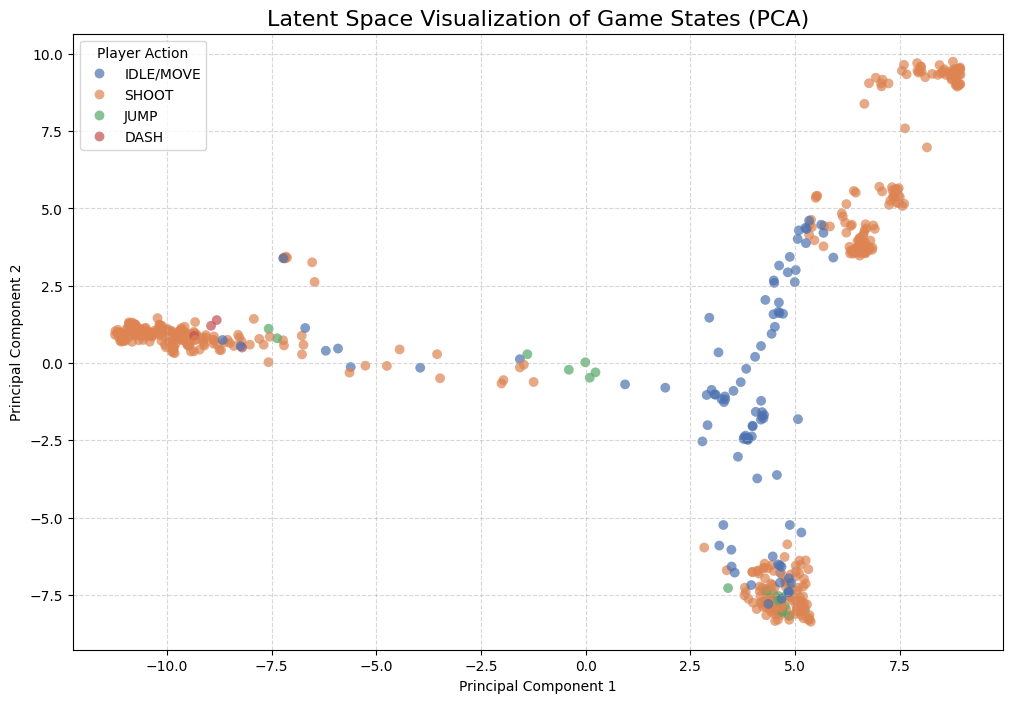

The PCA projection reveals that the Autoencoder’s latent vectors (from the initial 128-dimensional model) form structured clusters that correspond to distinct gameplay states:

*   **SHOOT (orange) →** tightly clustered in multiple regions
    *   Indicates the AE learned to differentiate between boss phases.
    *   Especially visible in the rightmost vertical cluster (Carrot phase), meaning the model encodes the boss’s spatial shift upward.
*   **IDLE/MOVE (blue) →** widely dispersed
    *   Reflects high visual diversity in neutral movement frames.
    *   Suggests the AE captured environmental variation such as background scrolling and Cuphead’s idle/move poses.
*   **JUMP (green) and DASH (red) →** appear as local micro-clusters
    *   These actions occur during fast transitions.
    *   Their separation from IDLE frames indicates that the AE successfully encodes the pose-specific geometry (e.g., Cuphead’s sprite distortion during jump/dash).


The PCA plot confirms that the AE was able to cluster visually distinct segments of the game (boss phases, movement patterns, jump poses).
This supports the assumption that the Autoencoder provides an informative and structured latent embedding for the RNN to operate on.

#### B. Reconstruction Quality (Qualitative Check)
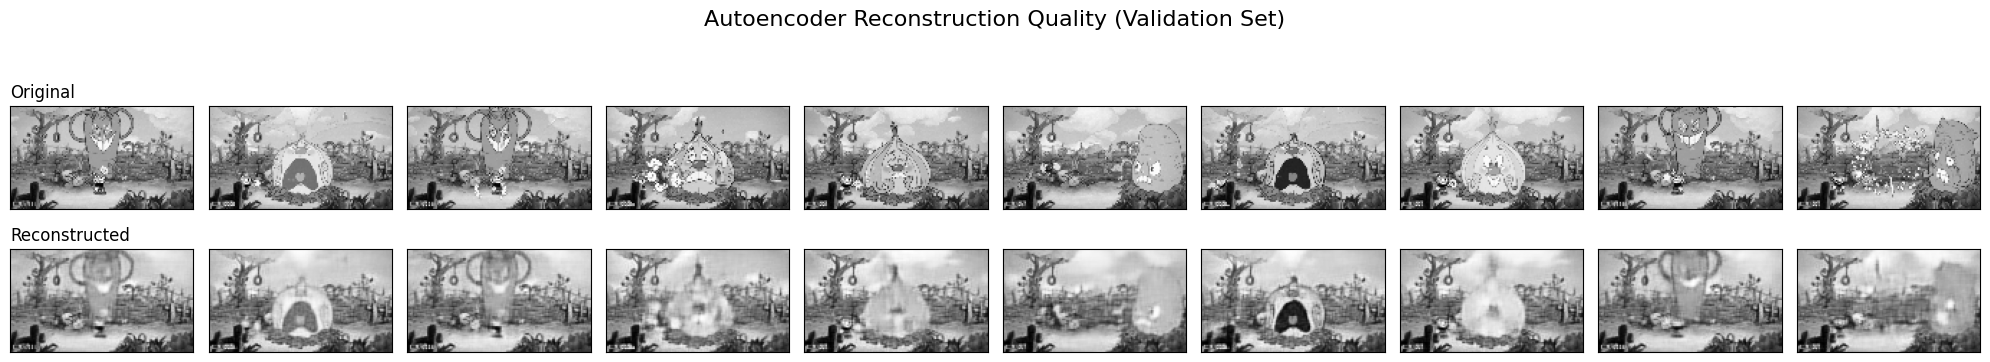
The reconstruction samples confirm that the Autoencoder retains the essential spatial cues required for gameplay:

*   Player character outline is preserved.
*   Projectile shapes remain visible.
    *   This is crucial for the RNN to infer projectile velocity across sequences.
*   Boss phase features (Potato/Onion/Carrot faces) remain visually distinct.



##### Interpretation

Although the reconstruction is not pixel-perfect (as expected from a compressed 128-dimensional latent vector), it preserves:

*   Relative geometry,
*   Silhouette information,
*   Projectile position and size, and
*   Key contrast boundaries.

This suggests that the latent representation contains enough detail for the recurrent model to detect:

*   Incoming danger (jump/dash prediction),
*   Boss location changes (Up key behavior),
*   And shoot-hold states.

#### Conclusion: Validity of the Latent Representation

Together, the PCA results and reconstruction examples demonstrate that:

*   The latent space clusters gameplay states meaningfully, forming the basis for phase-dependent actions (e.g., holding Up in Phase 3).
*   Dynamic actions (jump/dash) occupy distinct regions, confirming that the model encodes the short-term geometry needed for reflex actions.
*   The Autoencoder discards irrelevant background noise, benefiting the RNN’s ability to learn temporal patterns rather than overfitting visual clutter.

This validation supports the architectural choice of using a convolutional Autoencoder as the visual abstraction layer prior to the LSTM/GRU decision module.

### **3.2 The Decision Layer - LSTM vs GRU**
**Input-Output Definition:**
Before analyzing the internal gates, we must define the mathematical domain of the agent's decision process:
*   **Input ($Z_t$):** The input is a sequence of **Latent Vectors** generated by the Autoencoder, not raw pixels. Specifically, it is a tensor of shape $(10, 512)$, representing the last 1.0 second of gameplay history.
*   **Output ($\hat{y}_t$):** The network outputs a probability vector $\hat{y}_t \in [0, 1]^7$, representing the likelihood of pressing each of the 7 keys (Jump, Shoot, Dash, Up, Down, Left, Right).

To predict the correct action $y_t$ at the current frame, the model must understand the temporal context of the scene. Specifically, it must infer the **velocity vector** of incoming projectiles based on the sequence of past latent states $Z = \{z_{t-9}, \dots, z_t\}$ as discussed in Section 2.3.

I evaluated two Recurrent Neural Network (RNN) architectures to perform this sequence modeling.

#### **1. Long Short-Term Memory (LSTM)**

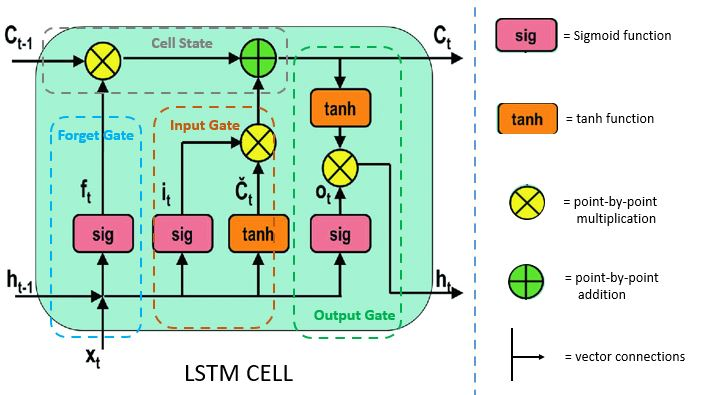

*Figure 2. LSTM Cell Architecture (from Introduction to LSTM units in RNN, by G. Singhal, 2020, Pluralsight)*

As illustrated in **Figure 2**, the LSTM architecture is defined by its **Cell State** ($C_t$, the top horizontal line). The cell is regulated by three distinct "gates" consisting of Sigmoid ($\sigma$) and Tanh neural network layers.

**Mathematical Formulation:**
In the equations below, $z_t$ represents our latent input vector (labeled as $x_t$ in Figure 2).

1.  **The Forget Gate ($f_t$ - Blue Box):** Decides what information to discard from the cell state. It looks at the previous hidden state $h_{t-1}$ and the current input $z_t$.
    $$ f_t = \sigma(W_f \cdot [h_{t-1}, z_t] + b_f) $$

2.  **The Input Gate ($i_t$ - Orange Box):** Decides what new information to store. A sigmoid layer ($i_t$) decides which values to update, while a tanh layer creates a vector of new candidate values ($\tilde{C}_t$).
    $$ i_t = \sigma(W_i \cdot [h_{t-1}, z_t] + b_i) $$
    $$ \tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, z_t] + b_C) $$

3.  **Cell State Update:** The old state $C_{t-1}$ is multiplied by $f_t$ (forgetting things), and the new candidate values are added.
    $$ C_t = f_t \odot C_{t-1} + i_t \odot \tilde{C}_t $$

4.  **The Output Gate ($o_t$ - Green Box):** Finally, the LSTM decides what to output ($h_t$) based on the filtered cell state.
    $$ o_t = \sigma(W_o \cdot [h_{t-1}, z_t] + b_o) $$
    $$ h_t = o_t \odot \tanh(C_t) $$

**Project Application:**
In the context of *Cuphead*, these gates perform specific roles in tracking game physics:
*   **Forget Gate ($f_t$):** Theoretically learns to "reset" memory when a threat is resolved. For example, if the latent vector $z_t$ indicates a projectile has exited the screen, $f_t \to 0$ for the neurons tracking that specific object's velocity.
*   **Output Gate ($o_t$):** This is crucial for the "Reflex" action. Even if the Cell State remembers a projectile exists ($C_t$), the Output Gate decides if it is *currently* dangerous enough to trigger a "Jump" command in the hidden state $h_t$.
*   **Why I tested this:** I hypothesized that this explicit separation of "Memory" ($C_t$) and "Action" ($h_t$) would allow the agent to track projectiles that are temporarily occluded or require delayed reactions.

#### **2. Gated Recurrent Unit (GRU)**
The GRU simplifies the LSTM by merging the Cell State and Hidden State into a single state $h_t$. It combines the Forget and Input gates into a single **Update Gate** ($z_t$).

**Mathematical Formulation:**
The Update Gate $z_t$ determines how much of the past information to pass along to the future:
$$ z_t = \sigma(W_z \cdot [h_{t-1}, z_t]) $$

The final hidden state $h_t$ is a linear interpolation between the previous state $h_{t-1}$ and the new candidate state $\tilde{h}_t$:
$$ h_t = (1 - z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t $$

**Performance Hypothesis**

I  hypothesized that the GRU would outperform the LSTM for this specific project.
1.  To dodge a projectile, the agent only needs to track its position over the last $\approx 10$ frames (1 second). It does *not* need to remember actions taken 30 seconds ago.
2.  The GRU's equation $h_t = (1 - z_t) \odot h_{t-1} \dots$ naturally models a **moving average**. This is mathematically equivalent to calculating momentum or velocity, which is the exact feature required to detect if an enemy is moving *towards* or *away* from the player.
3.  With a limited dataset of 15 sessions (approx. 9,500 samples), the LSTM's higher complexity led to overfitting (memorizing specific frame sequences). The GRU's simpler architecture forced it to generalize the physics of movement rather than memorizing the video.

#### **3.2.1 Why the Final Layer Uses a Sigmoid Activation**

After the recurrent layer (LSTM or GRU), the network outputs a vector of 7 real values, one for each action key (Jump, Shoot, Dash, Up, Down, Left, Right). These actions are not mutually exclusive—Cuphead can jump while shooting, or move left while dashing.

Therefore, the correct mathematical formulation is a multi-label binary classification problem, not a softmax-based single-label classification.

#### **Sigmoid Output Function**

The model computes:
```python
out = layers.Dense(NUM_ACTIONS, activation='sigmoid')(x)
```

Mathematically, each action probability is computed as:

$$
\hat{y}_{t,k} = \sigma(a_{t,k}) = \frac{1}{1 + e^{-a_{t,k}}}
$$

where:
- $a_{t,k}$ is the pre-activation logit for action $k$.
- $\sigma$ is the logistic sigmoid function mapping $\mathbb{R} \to (0, 1)$.
- $\hat{y}_{t,k}$ is interpreted as: “The probability that action $k$ should be pressed at time $t$”.

#### **Why Sigmoid is the Correct Choice**

*   Each keypress is modeled as an independent Bernoulli trial. A softmax would incorrectly force all probabilities to sum to 1.
*   Focal Loss applies directly to sigmoid logits for each key. Without sigmoid, the loss would be undefined.
*   A threshold (e.g., 0.5 during inference) naturally maps probability → keypress.

#### **Model Behavior Implications**

Using sigmoid allows the network to represent realistic combinations:
*   `Jump` + `Shoot`
*   `Left` + `Dash`
*   No action (all probabilities < threshold)

This directly aligns with human gameplay and real controller input patterns.

### **3.3 Optimization - Focal Loss**
**The Limitation of Cross-Entropy**
In the initial experiment, the model converged to a suboptimal local minimum: holding the "Shoot" button and never moving. This occurred because the model was optimized using standard **Binary Cross-Entropy (BCE)**:

$$ BCE(p_t) = -\log(p_t) $$

Since "Shoot" actions constitute most of the data, the cumulative loss is dominated by the majority class. The optimizer reduces global loss most efficiently by perfecting the "Shoot" prediction and ignoring the other keys' errors, as they contribute negligibly to the total cost.

**The Solution: Sigmoid Focal Loss**
To force the model to learn rare behaviors, I implemented **Focal Loss**. This adds a modulating factor $(1 - p_t)^\gamma$ to the BCE equation:

$$ FL(p_t) = -\alpha (1 - p_t)^\gamma \log(p_t) $$

*   **$p_t$:** The model's predicted probability for the true class.
*   **$\gamma$ (Gamma):** The focusing parameter (set to 2.0).

**Mechanism of Action:**
1.  **Easy Examples (Shooting):** If the model is 90% confident it should shoot ($p_t=0.9$), the modulating factor becomes $(1 - 0.9)^2 = 0.01$. The loss contribution is effectively silenced.
2.  **Hard Examples (Jumping):** If the model misses a jump ($p_t=0.2$), the factor becomes $(1 - 0.2)^2 = 0.64$. The loss remains high.

This mathematical modification reshapes the gradient landscape, forcing the optimizer to focus exclusively on the "hard" minority classes (Jumps/Dashes) rather than the easy majority class.

## **4. Results and Discussion**

### **4.1 Initial Model Evaluation (Majority Class Bias)**
The initial architecture (Autoencoder + LSTM) trained with standard Binary Cross-Entropy loss achieved a global binary accuracy of **97.31%**, which  measures the percentage of individual action bits correctly predicted as 0 or 1 across all frames and all keys (from the training session's output - Appendix A). However, a granular analysis of class-wise performance reveals that the model converged to a **trivial solution**. As the timeline shows, the high accuracy metric is misleading. The model only correctly predicts "Shoot" and "Up".  The 97.31% global binary accuracy reflects the model's success in predicting the "OFF" state for minority classes, rather than its ability to play the game.

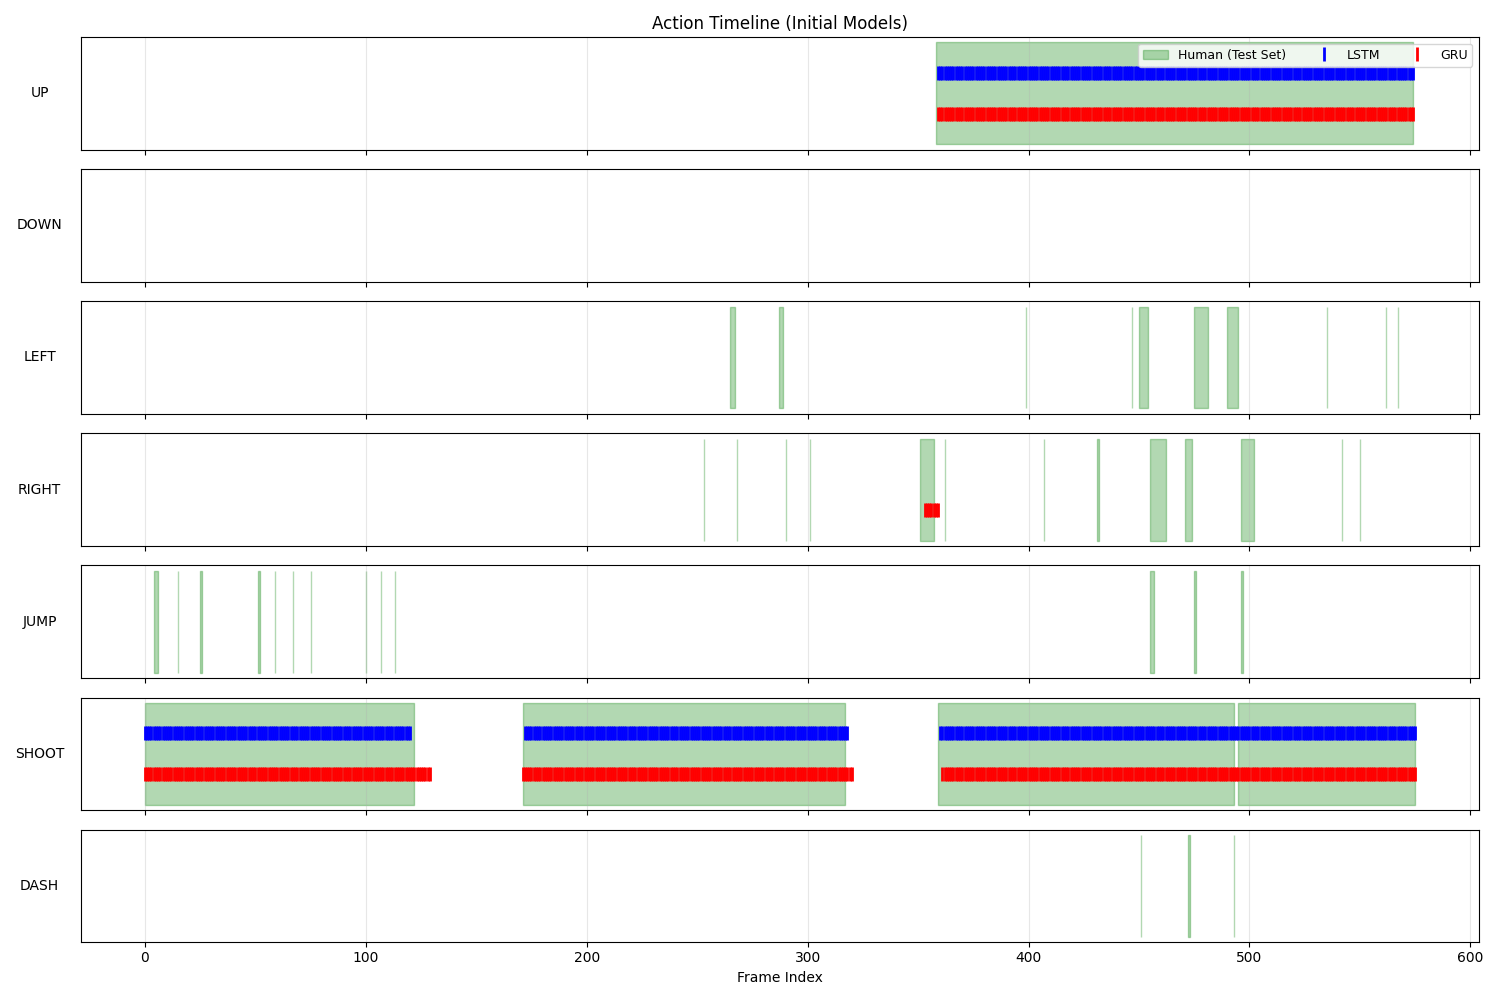

*Figure 3: Prediction timeline of human input vs. the initial model. The absence of activation in the JUMP, DASH, LEFT rows indicates a failure to learn minority class behaviors.*

**Heatmap Analysis (Figure 4):**
The quantitative breakdown in **Figure 4** confirms this behavioral failure. The F1-Scores for 'Jump', 'Dash', and 'Left' are **0.00**. The model completely suppressed these actions to minimize the penalty of False Positives. 
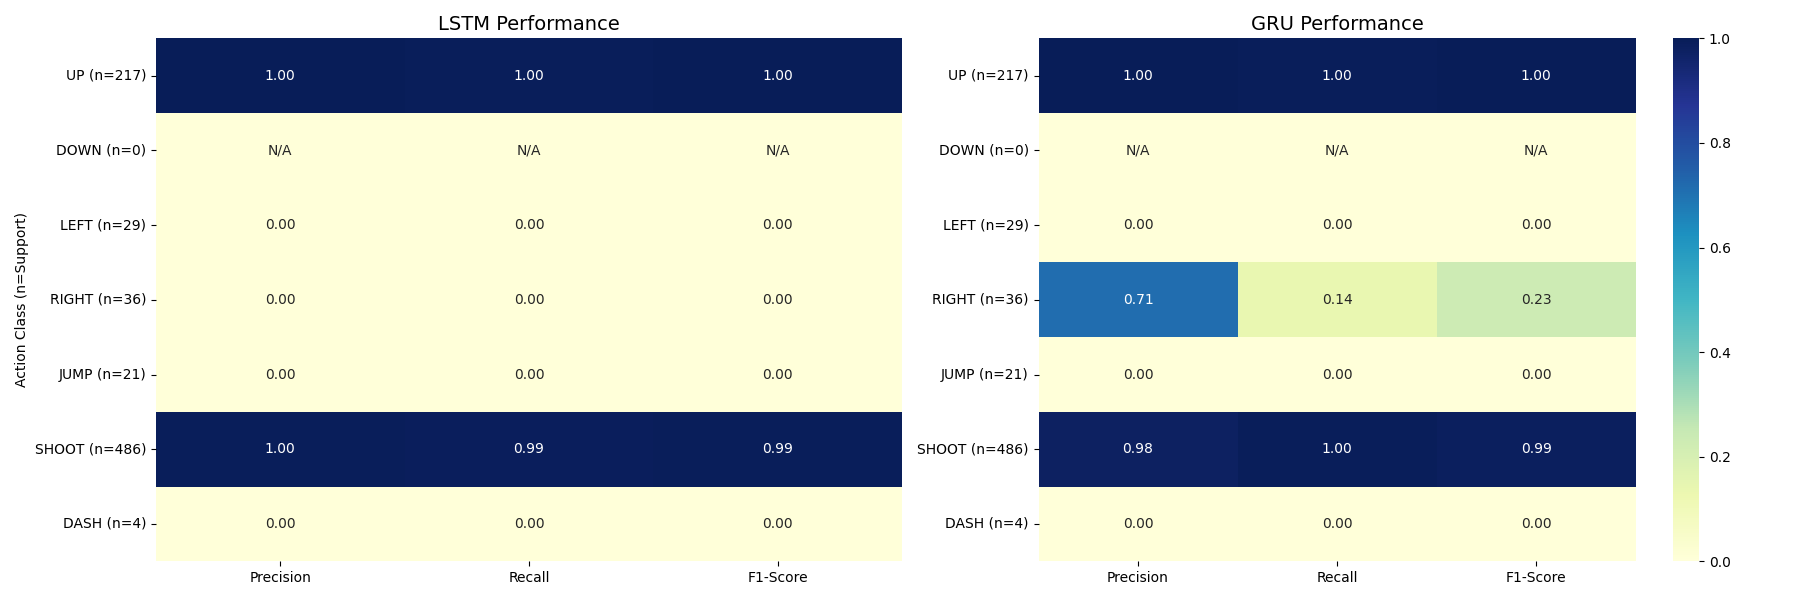

*Figure 4: Evaluation metrics heatmap (LSTM vs. GRU). Note the 0.00 scores for defensive mechanics.*

Interestingly, the model achieved perfect performance on 'Up' (F1=1.00) and 'Shoot' (F1=0.99). This indicates the model successfully learned **State-based actions** (holding a button for long durations based on the environment) but failed to learn **Reflex-based actions** (split-second reactions to movement).

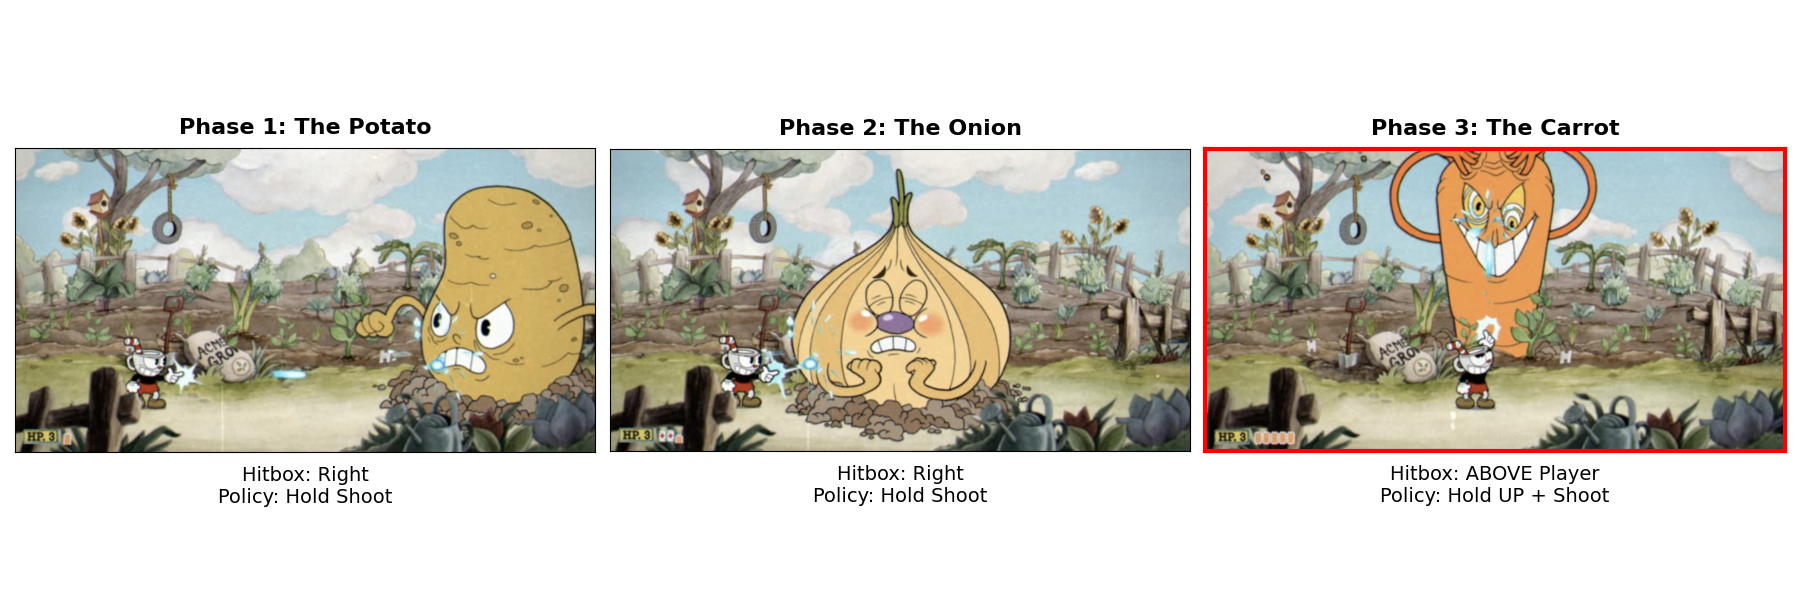

*Figure 5: Visual analysis of boss phases. The 'Up' action is semantically tied to the distinct visual features of Phase 3.*

As shown in **Figure 5**, the **'Up' key** is strictly correlated with **Phase 3 (The Carrot)**, where the enemy hitbox shifts from the right side to the top of the screen. The Autoencoder successfully learned to distinguish the semantic visual features of the "Carrot" from the "Potato" and "Onion," allowing the RNN to map this static visual state to the sustained action of holding 'Up'. Conversely, 'Jump' is a dynamic response to transient projectiles (velocity inference), which the baseline model ignored due to the overwhelming gradient from the majority class.


This confirms that standard accuracy is an invalid metric for imitation learning in sparse-event environments, necessitating the use of Focal Loss and F1-based evaluation.

### **4.2 Hyperparameter Optimization and Architecture Search**
To rectify the class imbalance, I introduced **Sigmoid Focal Loss** ($\gamma=2.0$) and conducted a grid search across **Latent Space Dimensions** $[128, 256, 512, 1024]$ and **Recurrent Cell Type** $[LSTM, GRU]$.

**Grid Search Results**

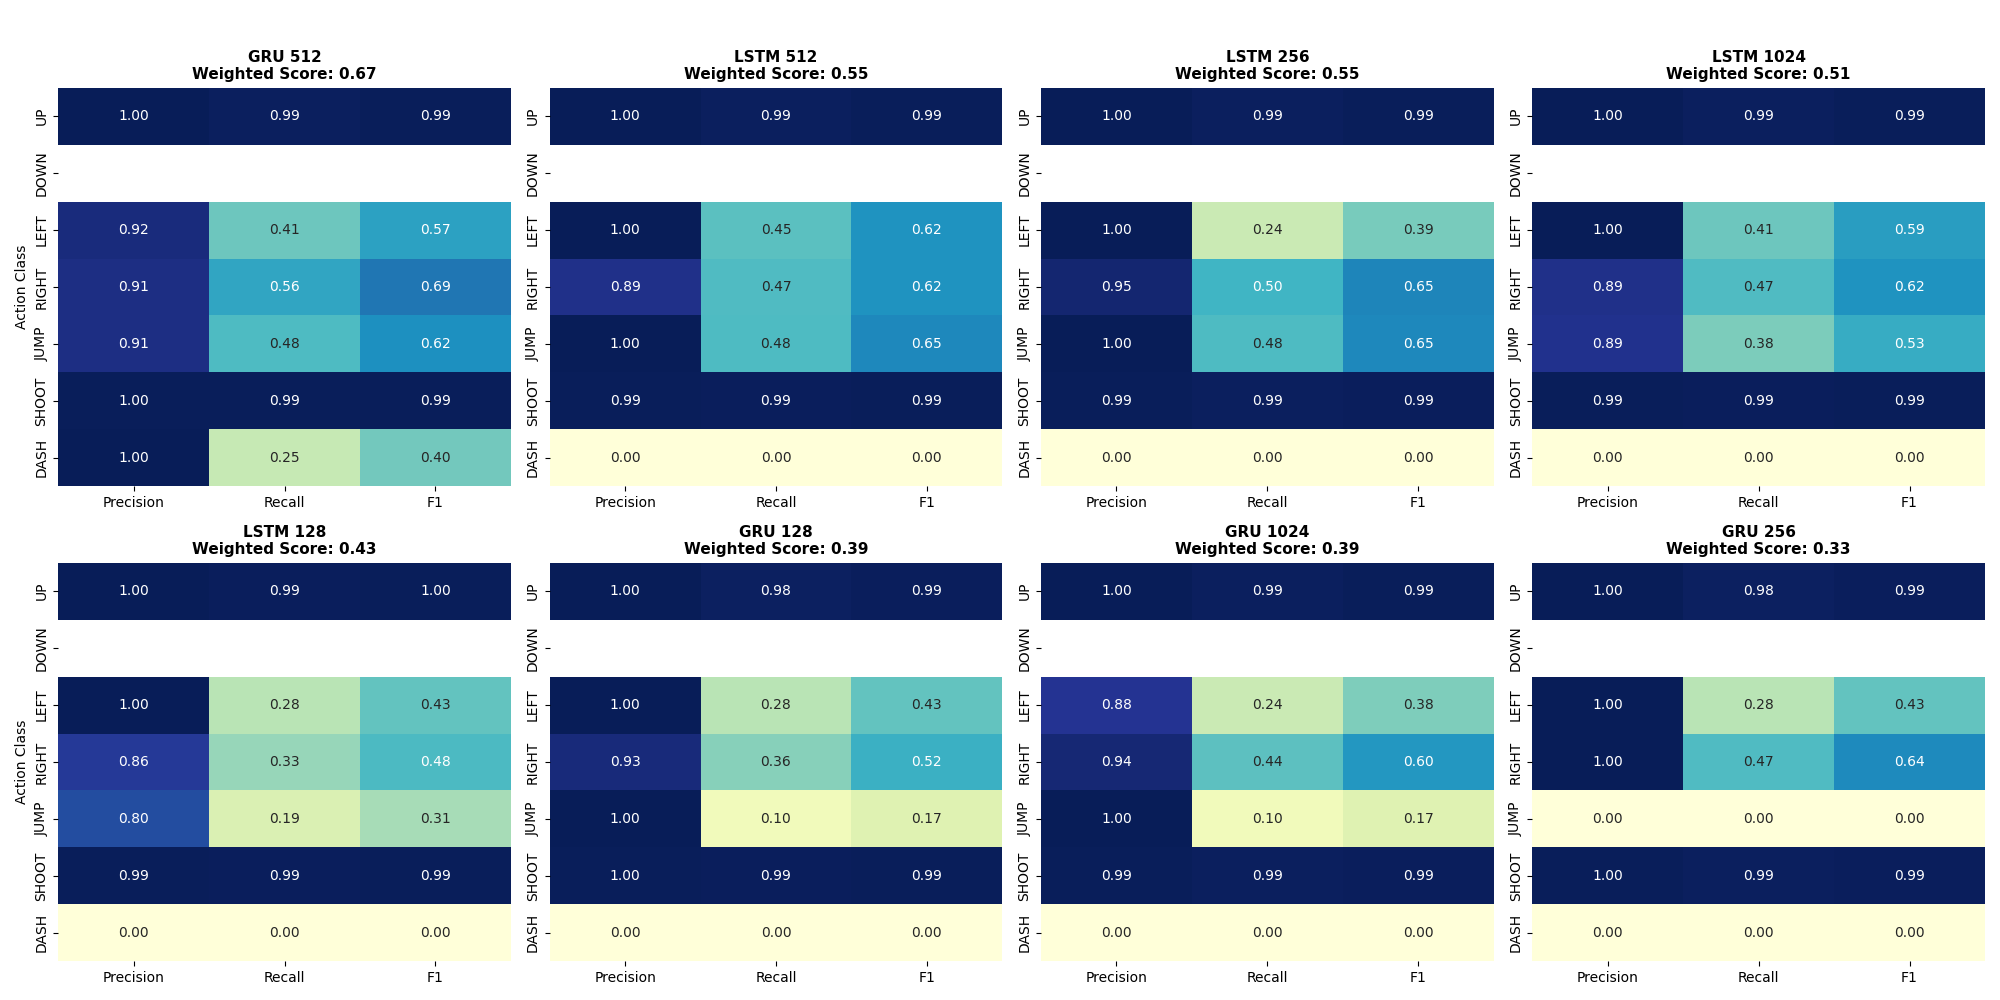

*Figure 6: Full Heatmap of evaluation metrics for each model. This visualization details the Precision, Recall, and F1-Score for every action class across all 8 model configurations.*

**Analysis of Results:**
1.  All 8 models achieved near-perfect F1-Scores for 'Up' ($>0.99$) and 'Shoot' ($>0.99$). This confirms that even the simplest architecture (Latent 128) successfully learned the semantic phase transition (Phase 3 = Hold Up + Shoot), validating the Autoencoder's ability to extract static game states.
2.  For dynamic actions like 'Left' and 'Right', all models exhibit high Precision ($>0.90$) but significantly lower Recall ($\approx 0.40 - 0.60$). This indicates that the models only commit to movement when the visual evidence is overwhelming, likely due to the high penalty of jittering in the loss function.

*(Note: The 'Down' action metrics are empty because the action was never used in the Test Session).*

#### **Metric Selection**
Since standard accuracy proved misleading in Section 4.1, I needed a metric that balances **Precision** (don't jump randomly) and **Recall** (jump when needed), specifically for the mechanics that matter most in *Cuphead*.

I calculated a **Weighted F1-Score** focusing on three critical indices:
1.  **JUMP (Index 4):** Survival mechanic.
2.  **SHOOT (Index 5):** Win condition.
3.  **DASH (Index 6):** Evasion mechanic.

**The Formula:**
$$ \text{Composite Score} = \frac{F1_{Jump} + F1_{Dash} + F1_{Shoot}}{3} $$

This metric penalizes models that spam buttons (low Precision $\to$ low F1) and models that are too passive (low Recall $\to$ low F1).

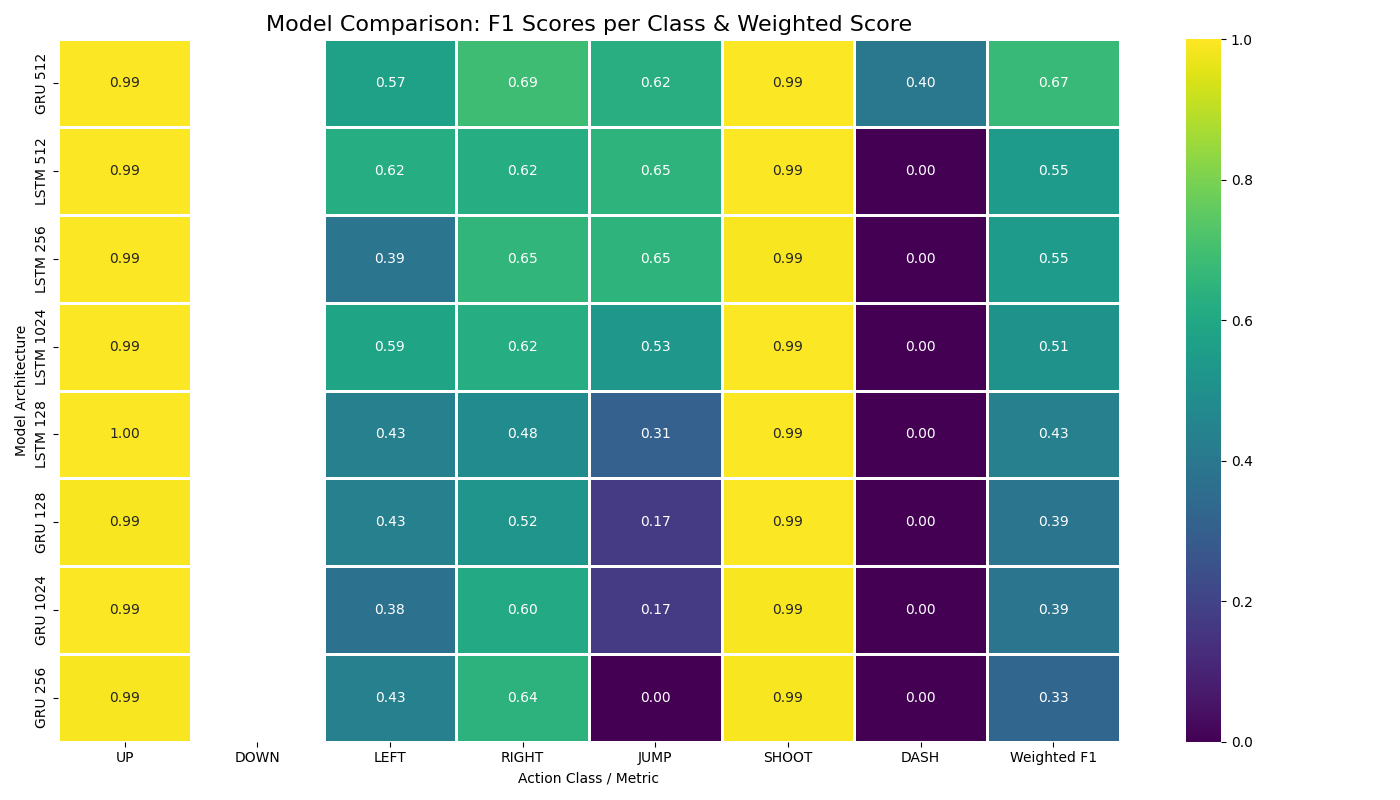

*Figure 7: Comparative performance of model architectures. The GRU-512 configuration (Row 6) achieves the highest composite score, balancing performance across all action classes.*

**Latent Capacity Trade-off:**
*   **128 Dimensions:** Failed to capture small projectiles (Composite Score $\approx 0.43$), resulting in poor hazard avoidance.
*   **512 Dimensions:** The optimal balance between detail retention and generalization.
*   **1024 Dimensions:** Performance degraded ($\approx 0.50$), indicating overfitting to background noise and irrelevant visual features.

#### **4.2-1 Optimal Model Performance: GRU (Latent 512)**

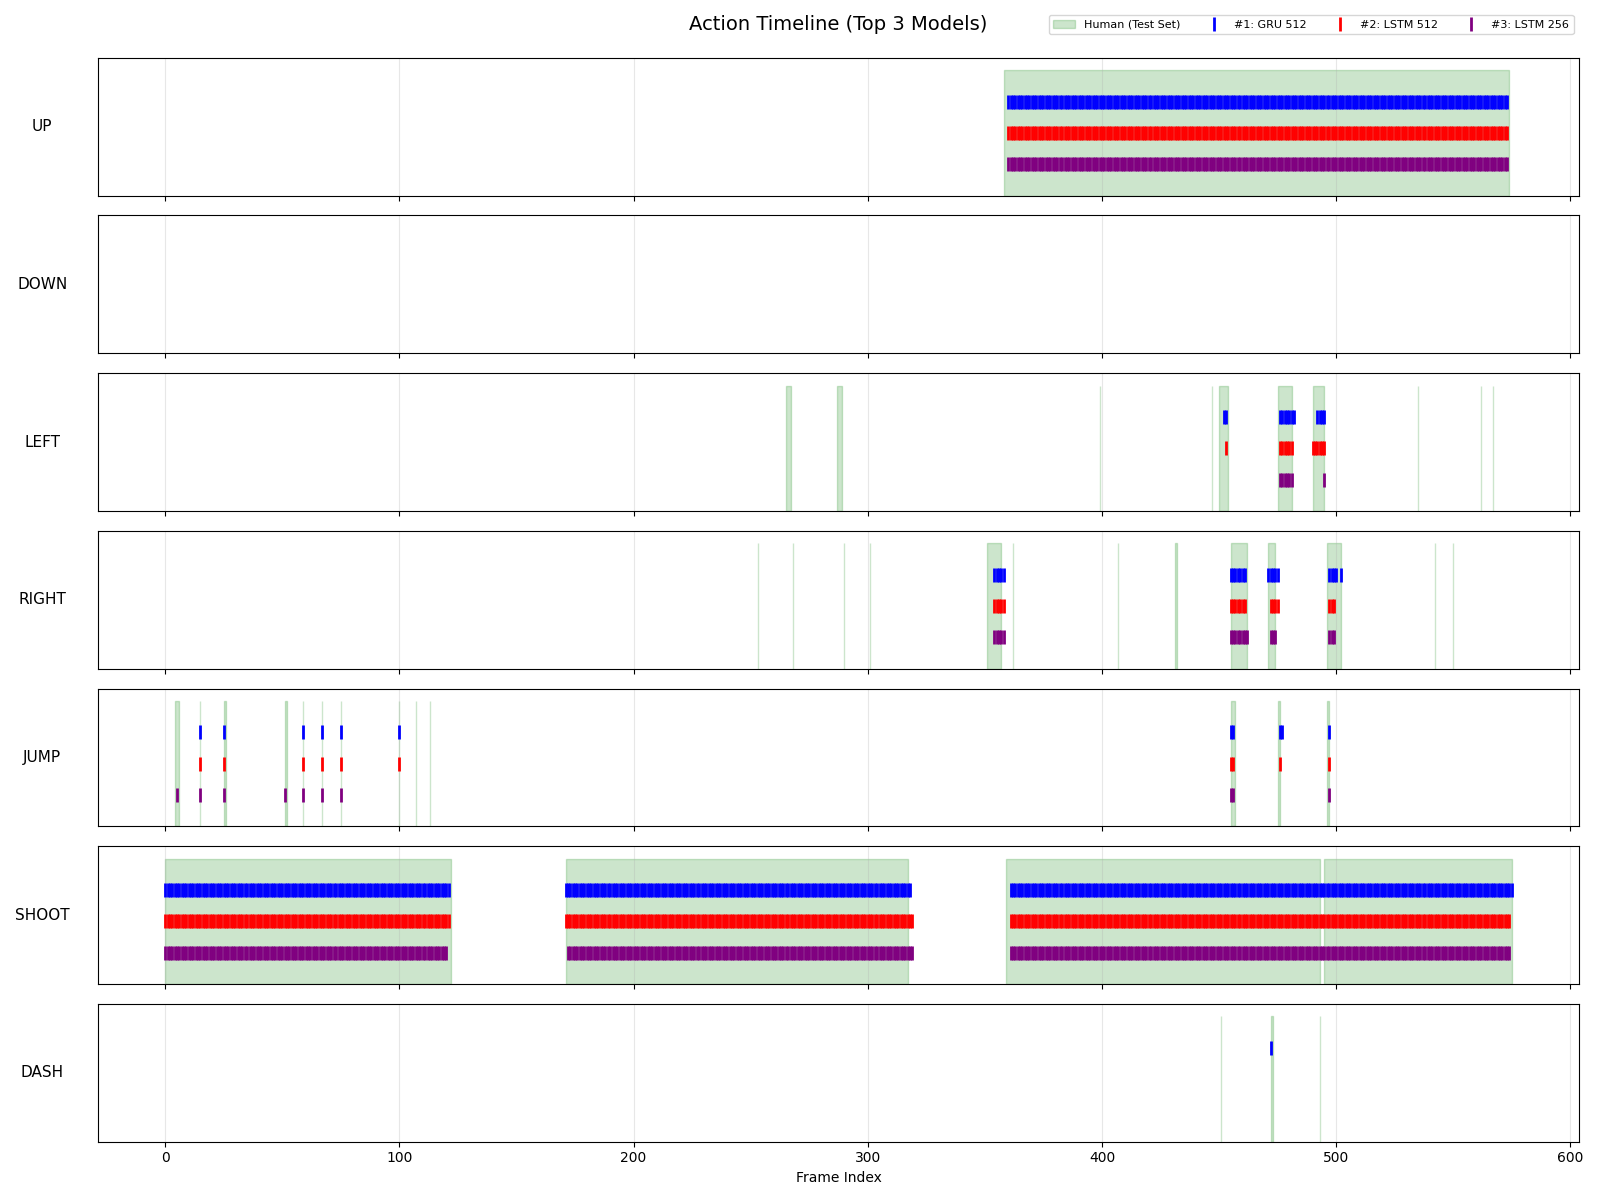

*Figure 8: Timeline comparison of the Top 3 models. This chart visualizes the action probabilities over time for the three best-performing architectures.*

#### **Overall Analysis**

The "Action Timeline" visualizes the temporal coherence of the top three models, revealing a clear distinction between performance on sustained states versus intermittent triggers. For high-frequency, continuous classes such as 'Shoot' and 'Up', all three architectures demonstrate near-perfect alignment with the human input (Green), indicating that both LSTM and GRU variants successfully mastered the dominant behavioral patterns. However, the model performance diverges significantly when predicting rare classes.

The superiority of the GRU-512 (Blue) is most evident in the **'Dash'** and **directional ('Left'/'Right')** timelines. While the LSTM models (Red and Purple) frequently fail to register isolated inputs, the GRU-512 demonstrates higher sensitivity to these rare events. Crucially, the 'Dash' timeline shows that the GRU-512 was the sole architecture to correctly identify the action impulse around frame 470, whereas both LSTM variants completely missed this event. This evidence supports the hypothesis that the GRU’s efficient gating mechanism allowed it to capture short-duration actions that the more complex LSTM architectures likely filtered out as noise or failed to memorize due to overfitting on dominant classes.
In summary, while all models captured general gameplay flow, the GRU-512 is identified as the optimal architecture due to its superior recall on rare, critical action triggers.

The final selected architecture was the **GRU with 512 Latent Dimensions**.

**Final Metrics (GRU-512):**
*   **JUMP F1:** **0.62** (Highest among all models).
*   **SHOOT F1:** **0.99**.
*   **DASH F1:** **0.40**.

### **4.3 Qualitative Analysis**
#### [Full Video (Youtube)](https://youtu.be/hAMK0MmIqaQ)

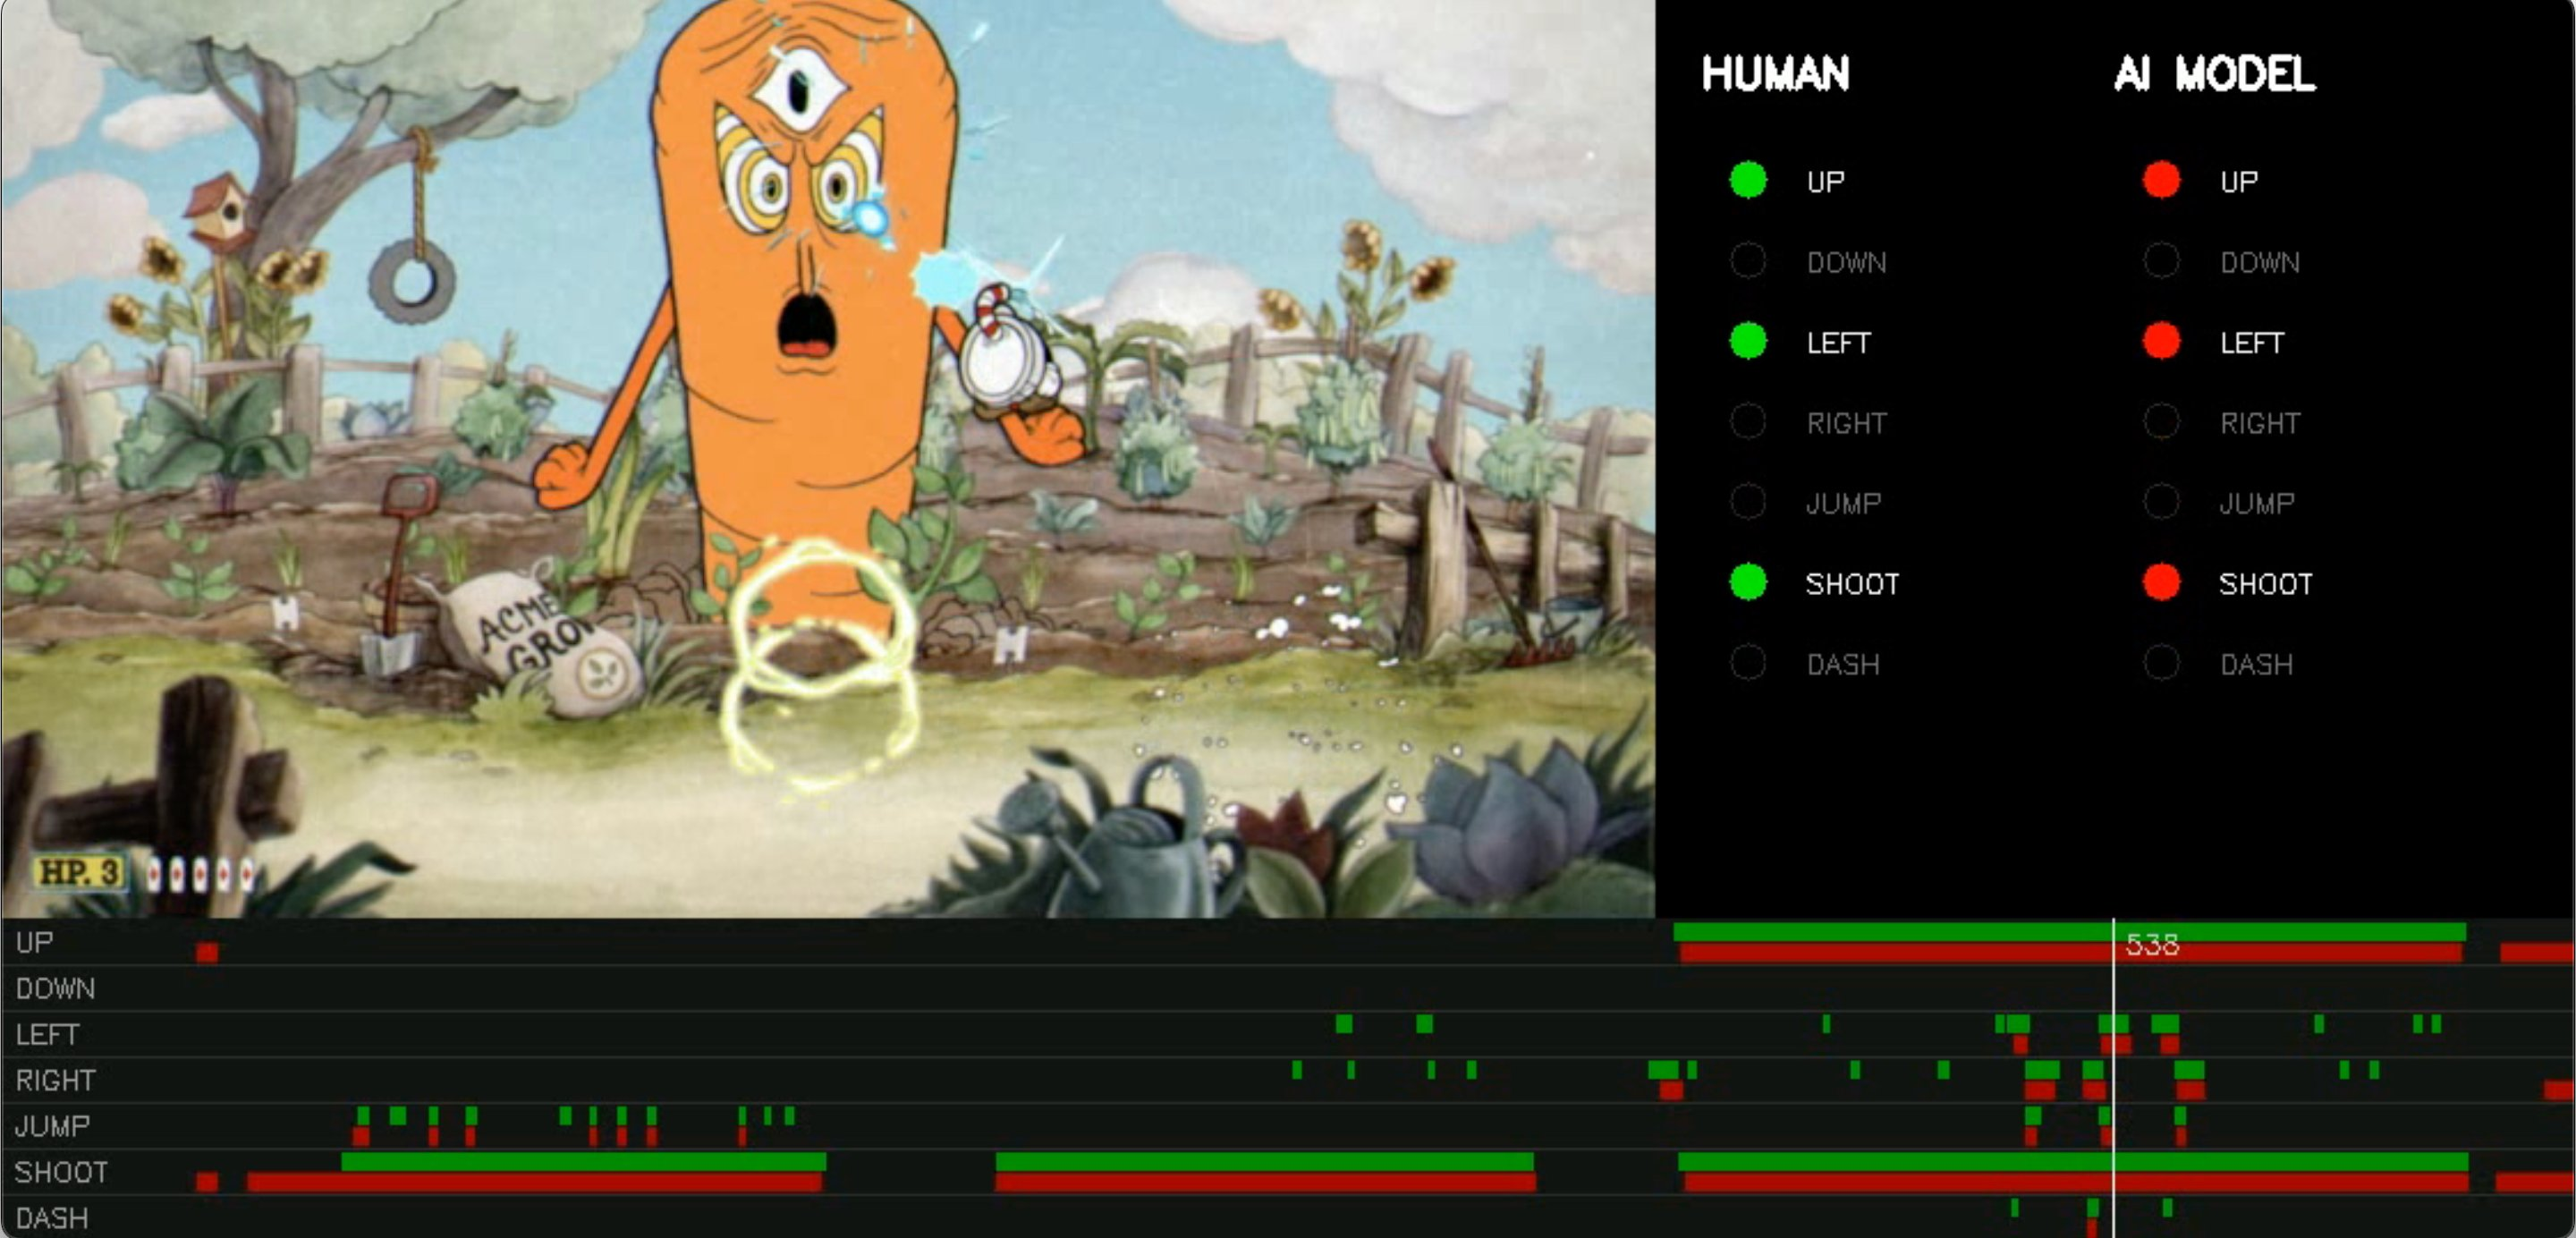

To validate the model's utility beyond static metrics, I generated a side-by-side video comparison overlaying the best model's predicted actions onto the test session gameplay.


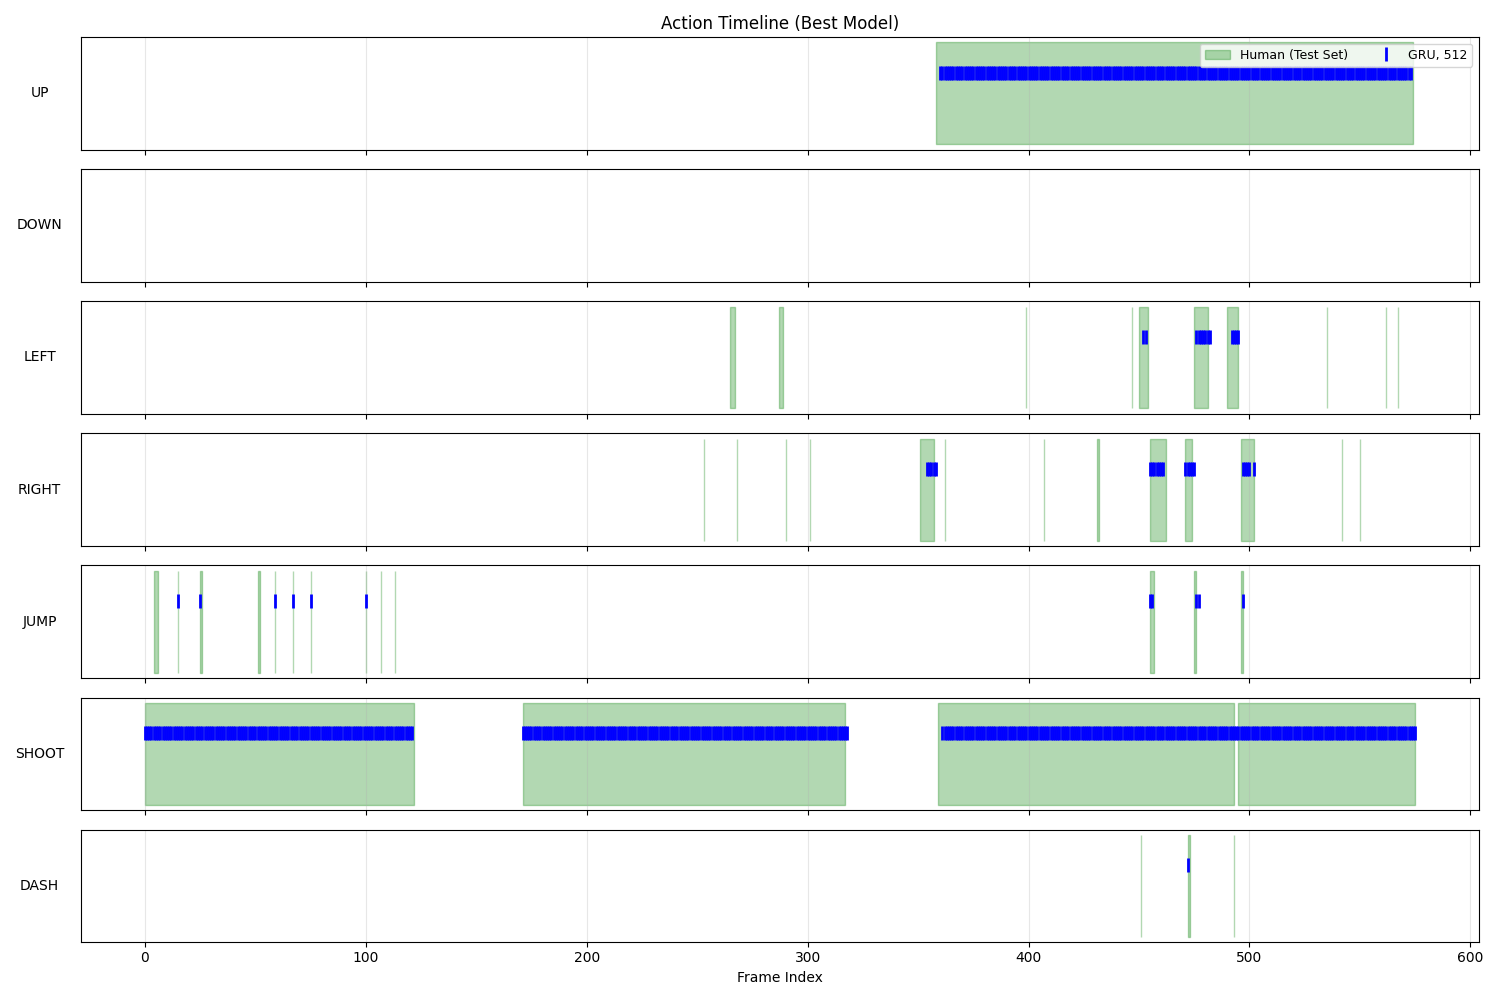

*Figure 9: Best Model Timeline Visualization. This timeline shows the precise activation of actions by the GRU-512 model compared to the ground truth.*

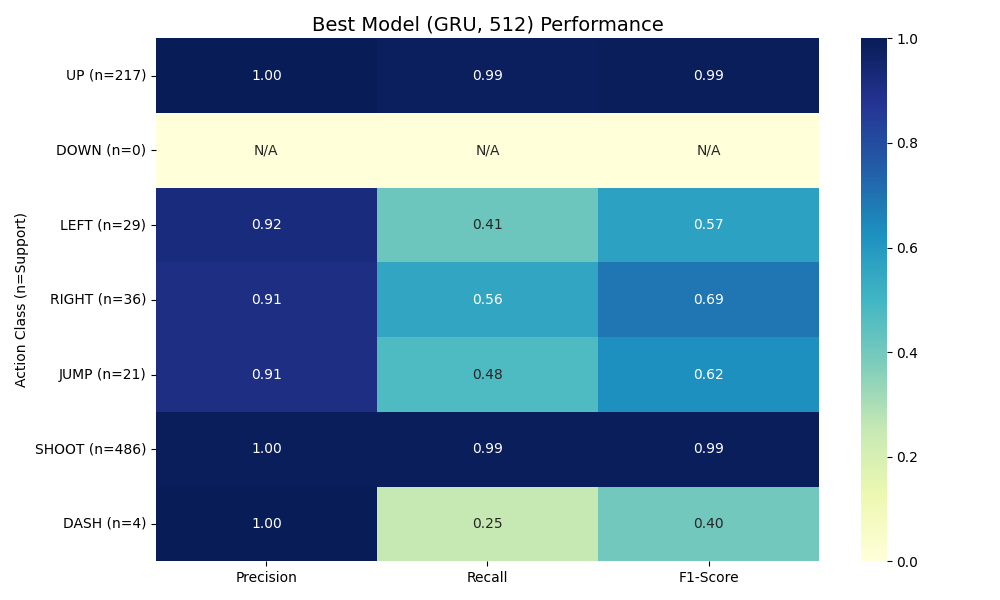

*Figure 10: Confusion Matrix/Heatmap for the Best Model (GRU-512). This heatmap illustrates the prediction accuracy across different action classes.*

#### **Final Observations**
1. The model demonstrates a clear distinction between its ability to handle state-dependent actions and its execution of rapid ones. As seen in Figure 9, the predictions for 'UP' and 'SHOOT' align almost perfectly with the ground truth, particularly during the visually distinct Phase 3 (the Carrot). This indicates the model successfully mapped a consistent game state to a long-term policy (i.e., "if carrot is on screen, hold up and shoot").
2. A consistent pattern of high precision but moderate-to-low recall emerges for all evasive actions ('LEFT', 'RIGHT', 'JUMP', 'DASH'). The heatmap in Figure 10 shows near-perfect precision for these moves (>0.91), meaning when the model does act, it is almost always correct. However, its lower recall scores (e.g., 0.48 for 'JUMP', 0.56 for 'RIGHT') reveal a "conservative" policy. The model has learned to avoid incorrect actions (False Positives) at the cost of missing some necessary ones (False Negatives), likely because the loss function penalizes erratic behavior more than inaction.
3. Despite its conservative nature, the model successfully captures high-stakes moments. A key success is the correct prediction of the rare 'DASH' action around frame 470 in Figure 9, demonstrating that the Focal Loss optimization successfully forced the model to learn even the most infrequent events. However, the extremely low recall for 'DASH' (0.25) highlights its primary limitation: while capable of reacting, it lacks the consistent, proactive timing of a human player, often missing the narrow window for execution. This suggests the model has learned what to do, but has not yet perfected when to do it.

#### **Limitations**

Since this model ignores rare and quick motions like dash and some of the jumps (as seen in the lower recall for 'Dash' in Figure 10), the 3-life restriction makes it difficult for this model to win the session purely on behavioral cloning, despite high precision.


#### **Future Direction**

The high precision but moderate recall for survival actions suggests that while the model has learned the "rules" of the game, it lacks the foresight to plan ahead. Future work will involve using Reinforcement Learning to fine-tune this pre-trained policy, allowing the agent to explore and learn the precise timing needed to win the game.

# References
Chollet, F. (2016, May 14). Building autoencoders in Keras. The Keras Blog. https://blog.keras.io/building-autoencoders-in-keras.html

Develeper. (2019, April 19). Cuphead A.I. - Using Machine Learning to Play Cuphead [Video]. YouTube. https://www.youtube.com/watch?v=wipq--gdIGM

IBM Technology. (2022, March 15). What are Autoencoders? [Video]. YouTube. https://www.youtube.com/watch?v=qiUEgSCyY5o

Singhal, G. (2020, September 9). Introduction to LSTM units in RNN [Diagram]. Pluralsight. https://www.pluralsight.com/resources/blog/guides/introduction-to-lstm-units-in-rnn

StatQuest with Josh Starmer. (2022, November 7). Long Short-Term Memory (LSTM), Clearly Explained [Video]. YouTube. https://www.youtube.com/watch?v=YCzL96nL7j0

# Appendices

# Appendix A: Model Training Code

## **1. Environment Setup and Reproducibility**
This notebook implements the training pipeline for an autonomous agent designed to play *Cuphead*. The architecture utilizes a two-stage approach: a convolutional Autoencoder for visual state abstraction, followed by Recurrent Neural Networks (LSTM/GRU) for temporal trajectory inference.

To ensure the scientific validity of the experiments—specifically the comparison between LSTM and GRU architectures—I must enforce strict determinism. The code below initializes the environment by fixing random seeds across the Python runtime, NumPy, and TensorFlow backends. This ensures that any performance divergence observed between models is attributed to architectural differences rather than random weight initialization or data shuffling artifacts.

In [ ]:
import os
import json
import gc
import random
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, backend
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score, precision_score, recall_score, f1_score

# Ensure Reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# Global Constants
FOLDER_NAME = "Dain_CS156_Assignment2"
BASE_PATH = f"/content/drive/My Drive/{FOLDER_NAME}"
EXPERIMENT_DIR = os.path.join(BASE_PATH, "Results")
os.makedirs(EXPERIMENT_DIR, exist_ok=True)

# Data Config
TRAIN_SESSIONS = ["Train"]
TEST_SESSION = "Test"
IMG_HEIGHT = 72
IMG_WIDTH = 128
SEQUENCE_LENGTH = 10
ACTION_ORDER = ['UP', 'DOWN', 'LEFT', 'RIGHT', 'JUMP', 'SHOOT', 'DASH']
NUM_ACTIONS = len(ACTION_ORDER)
KEY_MAP = {
    'Key.up': 'UP', 'Key.down': 'DOWN', 'Key.left': 'LEFT', 'Key.right': 'RIGHT',
    'Key.space': 'JUMP', 'f': 'SHOOT', 'd': 'DASH'
}

Mounted at /content/drive


## **2. Data Ingestion and Preprocessing Pipeline**

The raw data consists of high-definition gameplay recordings ($1280 \times 720$ RGB) paired with asynchronous event logs. Direct ingestion of this data is computationally infeasible and contains redundant information (color) irrelevant to the core game mechanics.

The following preprocessing pipeline transforms the raw unstructured data into a tensor format suitable for training:

1.  **Temporal Synchronization:** The `parse_events` and `build_timeline` functions map the asynchronous keystroke stream (measured in UTC timestamps) to discrete video frames. This resolves the variable frame rate drift inherent in screen recording.
2.  **Visual Transformation:**
    *   **Grayscale Conversion:** Reduces channel depth ($3 \to 1$) to focus on structural shapes (projectiles/enemies) rather than aesthetic color details.
    *   **Downsampling:** Resizes frames to $128 \times 72$. I chose this specific resolution to reduce the dimensionality of the input space while preserving the visibility of small, high-velocity projectiles.
3.  **Label Encoding:** Converting the set of active keys per frame into a Multi-Hot encoded vector representing the 7 available actions (Jump, Shoot, Dash, arrows).

In [ ]:
# helper functions for data cleaning and loading
def parse_events(event_path):
    """Parses JSONL event logs into sorted (timestamp, key, type) tuples."""
    events, intervals, curr_start = [], [], None
    if not os.path.exists(event_path): return [], []

    with open(event_path, 'r') as f:
        for line in f:
            try:
                d = json.loads(line)
                t = d.get('t')
                if t is None: continue

                # Markers for fight start/end
                if d.get('event') == 'marker':
                    if d.get('type') == 'fight_start': curr_start = t
                    elif d.get('type') == 'fight_end' and curr_start:
                        intervals.append((curr_start, t)); curr_start = None

                # Key Presses
                elif d.get('event') in ['keydown', 'keyup']:
                    k = d.get('key').strip("'").strip('"')
                    if k in KEY_MAP: events.append((t, k, d['event']))
            except: continue
    # Ensure chronological order for state reconstruction
    events.sort(key=lambda x: x[0])
    return intervals, events

def build_timeline(events, timestamps):
    """Reconstructs the set of active keys at specific frame timestamps."""
    active = set()
    timeline = []
    ev_idx, n_ev = 0, len(events)

    for t in timestamps:
        # Update active set based on events occurring before current frame time
        while ev_idx < n_ev and events[ev_idx][0] <= t:
            _, k, etype = events[ev_idx]
            if etype == 'keydown': active.add(k)
            elif etype == 'keyup': active.discard(k)
            ev_idx += 1
        timeline.append(set(active))
    return timeline

def load_dataset(sessions):
    """Loads video frames and aligns them with event logs."""
    X_buffer, y_buffer = [], []

    for session in sessions:
        vid_path = os.path.join(BASE_PATH, f"{session}.mp4")
        evt_path = os.path.join(BASE_PATH, f"{session}_events.jsonl")
        frm_path = os.path.join(BASE_PATH, f"{session}_frames.jsonl")

        with open(frm_path, 'r') as f:
            timestamps = [json.loads(line)['t'] for line in f]

        intervals, events = parse_events(evt_path)
        timeline = build_timeline(events, timestamps)

        cap = cv2.VideoCapture(vid_path)
        idx = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret: break
            if idx >= len(timestamps): break

            t = timestamps[idx]
            # Filter frames outside fight markers to reduce noise
            if any(start <= t <= end for start, end in intervals):
                # Preprocessing: Resize -> Grayscale -> Normalize
                frame = cv2.resize(frame, (IMG_WIDTH, IMG_HEIGHT))
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).astype('float32') / 255.0
                X_buffer.append(np.expand_dims(frame, axis=-1))

                # Label Encoding
                lbl = np.zeros(NUM_ACTIONS, dtype=np.float32)
                for k in timeline[idx]:
                    if KEY_MAP[k] in ACTION_ORDER:
                        lbl[ACTION_ORDER.index(KEY_MAP[k])] = 1.0
                y_buffer.append(lbl)
            idx += 1
        cap.release()

    return np.array(X_buffer), np.array(y_buffer)

def create_sequences_baseline(features, labels, seq_len):
    X_seq, y_seq = [], []
    # Iterate through the dataset creating overlapping windows
    for i in range(seq_len, len(features)):
        # The window of past frames
        X_seq.append(features[i-seq_len:i])
        # The target action at current time
        y_seq.append(labels[i])
    return np.array(X_seq), np.array(y_seq)

### **Data Loading**
I load the training sessions (mixed win/loss gameplay) and a separate validation session. The validation set is a distinct "Test Session" recorded separately to evaluate the model's generalization capabilities on unseen projectile patterns.

In [ ]:
# load dataset
X_train, y_train = load_dataset(TRAIN_SESSIONS)
X_val, y_val = load_dataset([TEST_SESSION])

print(f"Dataset Loaded. Train: {X_train.shape}, Val: {X_val.shape}")
gc.collect()

Dataset Loaded. Train: (9549, 72, 128, 1), Val: (590, 72, 128, 1)


0

## **3. Phase 1: Initial Architecture (State Abstraction)**

### **3.1 The Vision Layer (Convolutional Autoencoder)**
Before the agent can learn *how* to react, it must learn *what* it is seeing. Treating the $128 \times 72$ input as a flat vector destroys spatial topology. Instead, I implement a Convolutional Autoencoder.

**Algorithm:**
The network consists of two components trained simultaneously to minimize Mean Squared Error (MSE) between the input $x$ and reconstruction $\hat{x}$:
1.  **Encoder ($E_\phi$):** A series of `Conv2D` and `MaxPooling2D` layers that compress the input image into a low-dimensional Latent Vector $z$. This forces the network to discard high-frequency noise (background static) and retain semantic features (enemy coordinates).
2.  **Decoder ($D_\theta$):** Upsamples the latent vector back to the original resolution.

In this initial phase, I utilize a **Latent Dimension of 128** to establish a lower bound for performance.

### **3.2 Feature Extraction and Temporal Sequencing**
Once the Autoencoder is trained, I discard the Decoder. I use the frozen Encoder to transform every frame in the dataset into its latent representation $z_t$.

**Sliding Window:**
Static frames lack velocity information. To allow the RNN to infer the trajectory of projectiles, I construct sequences using a sliding window approach.
*   **Input:** A sequence of $T=10$ latent vectors ($z_{t-9}, \dots, z_t$).
*   **Target:** The action vector $y_t$ at the current frame.

This transforms the problem from simple image classification to sequence-to-sequence modeling, enabling the detection of object momentum.

In [ ]:
input_img = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same', name="Latent_128")(x)

# Decoder
x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Compilation & Training
baseline_ae = models.Model(input_img, decoded)
baseline_encoder = models.Model(input_img, encoded)
baseline_ae.compile(optimizer='adam', loss='mse')

baseline_ae.fit(X_train, X_train, epochs=10, batch_size=32, validation_data=(X_val, X_val), verbose=1)
baseline_encoder.save(os.path.join(EXPERIMENT_DIR, "1_encoder.keras"))

# Extract feature from the encoder
X_train_latent = baseline_encoder.predict(X_train, batch_size=64, verbose=0)
X_val_latent = baseline_encoder.predict(X_val, batch_size=64, verbose=0)

# Flatten for RNN (N, H*W*C)
flat_dim = np.prod(X_train_latent.shape[1:])
X_train_flat = X_train_latent.reshape(X_train_latent.shape[0], flat_dim)
X_val_flat = X_val_latent.reshape(X_val_latent.shape[0], flat_dim)

# generate sequence
X_train_seq, y_train_seq = create_sequences_baseline(X_train_flat, y_train, SEQUENCE_LENGTH)
X_val_seq, y_val_seq = create_sequences_baseline(X_val_flat, y_val, SEQUENCE_LENGTH)


Epoch 1/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - loss: 0.0234 - val_loss: 0.0106
Epoch 2/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0096 - val_loss: 0.0077
Epoch 3/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0075 - val_loss: 0.0065
Epoch 4/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0066 - val_loss: 0.0059
Epoch 5/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0060 - val_loss: 0.0054
Epoch 6/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0056 - val_loss: 0.0052
Epoch 7/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0053 - val_loss: 0.0049
Epoch 8/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0051 - val_loss: 0.0047
Epoch 9/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0049 - val_loss: 0.0045
Epoch 10/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0047 - val_loss: 0.0044


### 1. Visualize reconstruction samples & validate projectile preservation
To evaluate the autoencoder's quality, we compare original frames from the validation set (X_val) against the frames reconstructed by the autoencoder. This visually confirms whether critical game elements, such as small projectiles, are preserved after compression, which is crucial for the agent's decision-making.

### 2. Compute and visualize the latent space
We use Principal Component Analysis (PCA) to reduce the high-dimensional latent space into two dimensions for visualization. Each point in the plot represents a single game frame. Points are colored based on the player's action at that frame. This helps us understand if the encoder has learned to group similar game states (e.g., all "JUMP" states) together in the latent space.


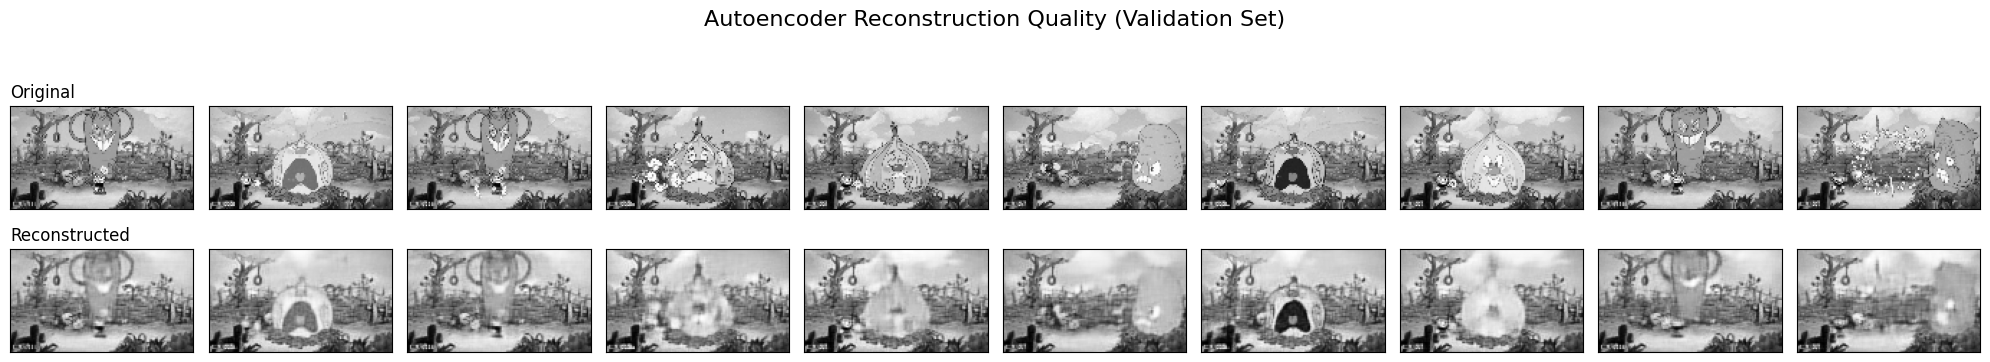

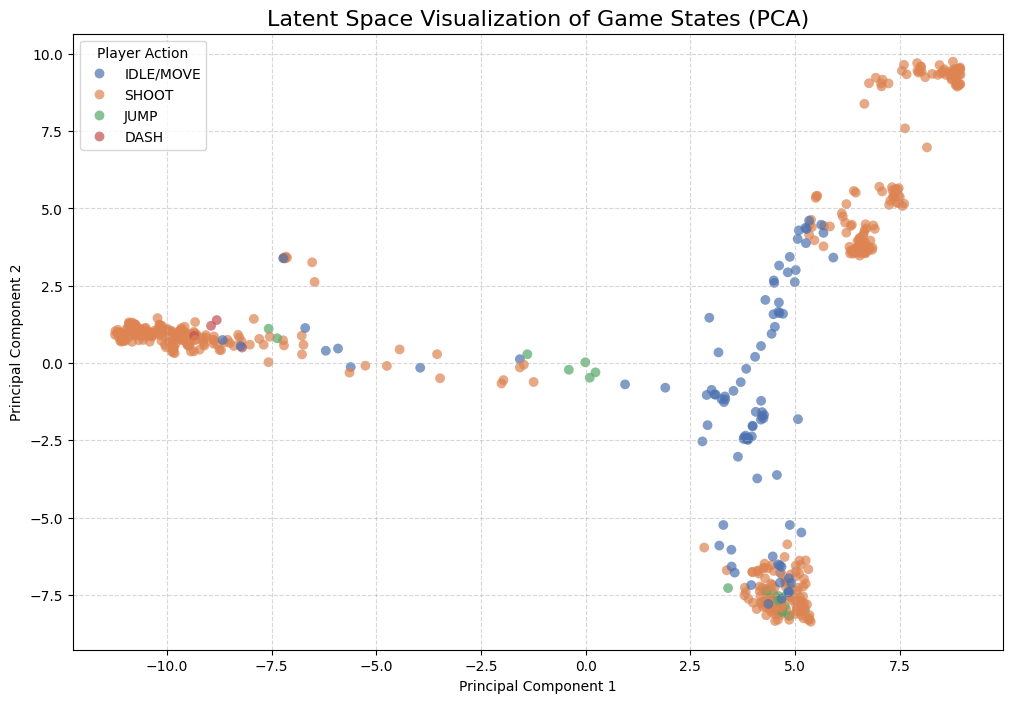

In [ ]:
reconstructed_imgs = baseline_ae.predict(X_val, batch_size=64, verbose=0)

# Select 10 random samples to display
n_samples = 10
sample_indices = np.random.choice(range(len(X_val)), n_samples, replace=False)

plt.figure(figsize=(20, 4))
for i, idx in enumerate(sample_indices):
    # Display original
    ax = plt.subplot(2, n_samples, i + 1)
    plt.imshow(X_val[idx].reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        ax.set_title("Original", loc='left', fontsize=12)

    # Display reconstruction
    ax = plt.subplot(2, n_samples, i + 1 + n_samples)
    plt.imshow(reconstructed_imgs[idx].reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        ax.set_title("Reconstructed", loc='left', fontsize=12)

plt.suptitle("Autoencoder Reconstruction Quality (Validation Set)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Use the flattened latent vectors from the validation set (X_val_flat)
pca = PCA(n_components=2)
X_val_pca = pca.fit_transform(X_val_flat)

# Create categorical labels from y_val for coloring the plot
# (y_val is aligned with X_val and thus X_val_flat)
action_labels = []
for i in range(len(y_val)):
    label = "IDLE/MOVE" # Default label
    if y_val[i, ACTION_ORDER.index('JUMP')] == 1:
        label = "JUMP"
    elif y_val[i, ACTION_ORDER.index('DASH')] == 1:
        label = "DASH"
    elif y_val[i, ACTION_ORDER.index('SHOOT')] == 1:
        label = "SHOOT"
    action_labels.append(label)

# Plot the 2D latent space
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=X_val_pca[:, 0],
    y=X_val_pca[:, 1],
    hue=action_labels,
    palette="deep",
    alpha=0.7,
    s=50,
    linewidth=0
)
plt.title('Latent Space Visualization of Game States (PCA)', fontsize=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title="Player Action")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

---
### **3.3 Initial Decision Layer (Majority Class Bias Check)**
Here, I train the initial recurrent heads (LSTM and GRU) using standard **Binary Cross-Entropy (BCE)** loss.

**Objective:**
The purpose of this step is to empirically demonstrate the impact of Class Imbalance. In *Cuphead*, the 'Shoot' action is active for the majority of frames, while 'Jump' and 'Dash' are sparse events. I hypothesize that a standard BCE optimization will result in a trivial local minimum where the model learns to constantly predict the majority class ("Shoot") and suppresses the minority classes to minimize global error.

In [ ]:
# Train RNN models (LSTM & GRU)
for rnn_type in ["LSTM", "GRU"]:
    print(f"Training {rnn_type}...")
    # Input: Sequence of flattened feature vectors (Time steps x Features)
    inp = layers.Input(shape=(SEQUENCE_LENGTH, flat_dim))

    if rnn_type == "LSTM":
        # return_sequences=True allows stacking by passing the full sequence to the next layer
        x = layers.LSTM(128, return_sequences=True)(inp)
        x = layers.Dropout(0.3)(x)
        # Final layer compresses temporal information into a single context vector
        x = layers.LSTM(64)(x)
    else:
        x = layers.GRU(128, return_sequences=True)(inp)
        x = layers.Dropout(0.3)(x)
        x = layers.GRU(64)(x)

    # Sigmoid activation with binary crossentropy handles multi-label classification (concurrent keys)
    out = layers.Dense(NUM_ACTIONS, activation='sigmoid')(x)
    model = models.Model(inp, out)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

    model.fit(
        X_train_seq, y_train_seq,
        epochs=15,
        batch_size=32,
        validation_data=(X_val_seq, y_val_seq),
        verbose=1
    )

    model.save(os.path.join(EXPERIMENT_DIR, f"1_{rnn_type.lower()}.keras"))

    del model
    gc.collect()

Training LSTM...
Epoch 1/15
299/299 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - binary_accuracy: 0.9324 - loss: 0.2124 - val_binary_accuracy: 0.9732 - val_loss: 0.1081
Epoch 2/15
299/299 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - binary_accuracy: 0.9601 - loss: 0.1334 - val_binary_accuracy: 0.9756 - val_loss: 0.0945
Epoch 3/15
299/299 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - binary_accuracy: 0.9614 - loss: 0.1272 - val_binary_accuracy: 0.9749 - val_loss: 0.0958
Epoch 4/15
299/299 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - binary_accuracy: 0.9624 - loss: 0.1257 - val_binary_accuracy: 0.9741 - val_loss: 0.0972
Epoch 5/15
299/299 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - binary_accuracy: 0.9639 - loss: 0.1215 - val_binary_accuracy: 0.9759 - val_loss: 0.0911
Epoch 6/15
299/299 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - binary_accuracy: 0.9637 - loss: 0.1218 - val_binary_accuracy: 0.9756 - val_loss: 0.0900
Epoch 7/15
299/299 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - binary_accuracy: 0.9644 - loss: 0.1177 - val_binary_accuracy: 0.9741 

## **4. Initial Evaluation**
I visualize the predictions of the initial models against the human input. A "flatline" in the prediction plots for dynamic actions (Jump/Dash) will confirm that the model has succumbed to majority class bias, necessitating the use of advanced loss functions.

SECTION 1 EVALUATION: METRICS & TIMELINE


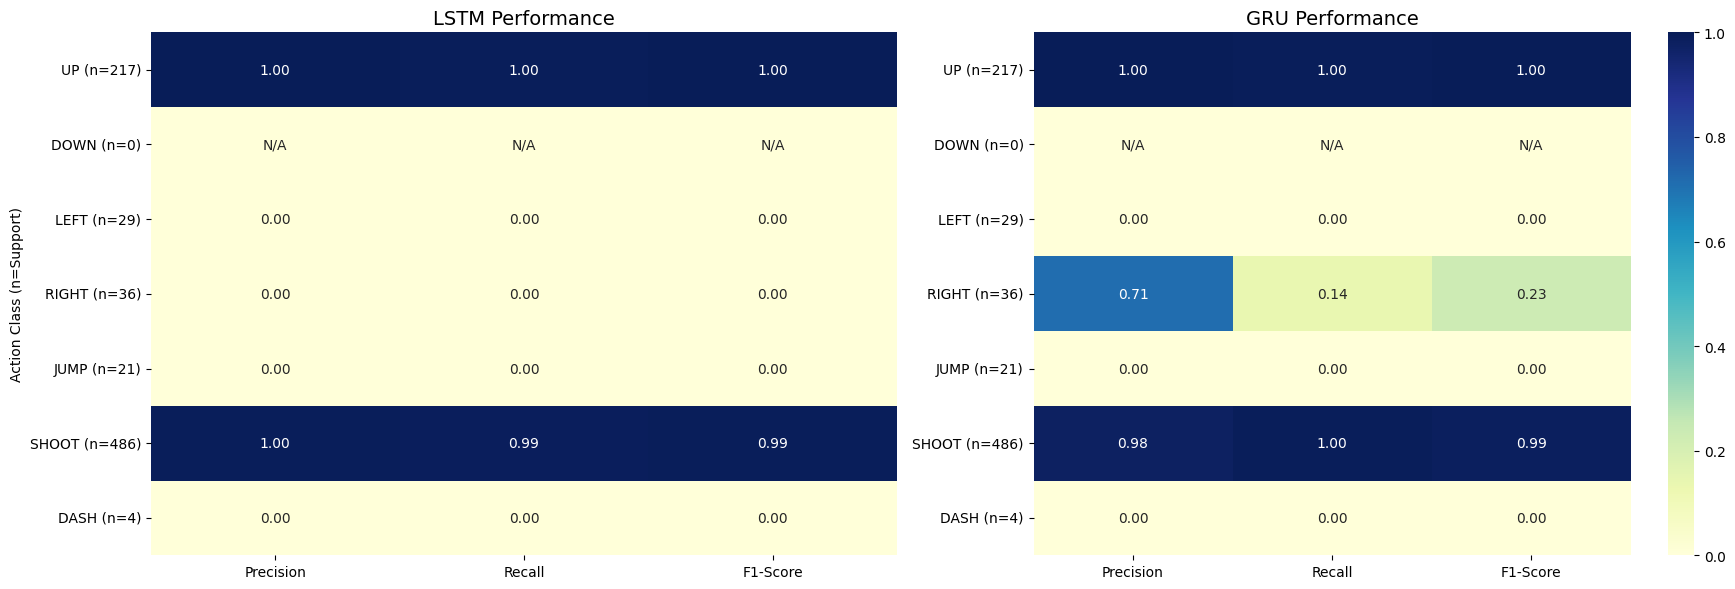

In [ ]:
print("INITIAL MODEL EVALUATION: METRICS & TIMELINE")

# Load models
encoder = models.load_model(os.path.join(EXPERIMENT_DIR, "1_encoder.keras"))
model_lstm = models.load_model(os.path.join(EXPERIMENT_DIR, "1_lstm.keras"))
model_gru = models.load_model(os.path.join(EXPERIMENT_DIR, "1_gru.keras"))

# Load Test Session
X_test_raw, y_test_raw = load_dataset([TEST_SESSION])

# Encode & Create Sequences
X_test_latent = encoder.predict(X_test_raw, batch_size=64, verbose=0)

# Flatten Latent Space
flat_dim = np.prod(X_test_latent.shape[1:])
X_test_flat = X_test_latent.reshape(X_test_latent.shape[0], flat_dim)

# Create Sequences
X_test_seq, y_test_seq = create_sequences_baseline(X_test_flat, y_test_raw, SEQUENCE_LENGTH)

def get_model_metrics_viz(model):
    """
    Generates:
    1. df: Numeric values for heatmap colors (Precision, Recall, F1 only).
    2. annot: Text values for heatmap cells (Handles 'N/A').
    3. y_labels: List of strings like 'UP (n=200)' to show support on axis.
    """
    # Predict
    y_pred_probs = model.predict(X_test_seq, verbose=0)
    y_pred = (y_pred_probs > 0.5).astype(int)

    # Calculate raw metrics
    precision, recall, f1, support = precision_recall_fscore_support(y_test_seq, y_pred, average=None, zero_division=0)

    # Create Numeric DataFrame (Only 0-1 metrics for proper coloring)
    df = pd.DataFrame({
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    }, index=ACTION_ORDER)

    # Create Annotation DataFrame (for Text)
    annot = df.copy().astype(object)

    # Create Custom Y-Axis Labels with Support Count
    y_labels = []

    for i in range(len(df)):
        supp = int(support[i])
        # Add support to label
        y_labels.append(f"{ACTION_ORDER[i]} (n={supp})")

        if supp == 0:
            annot.iloc[i, 0] = "N/A"
            annot.iloc[i, 1] = "N/A"
            annot.iloc[i, 2] = "N/A"
        else:
            annot.iloc[i, 0] = f"{df.iloc[i, 0]:.2f}"
            annot.iloc[i, 1] = f"{df.iloc[i, 1]:.2f}"
            annot.iloc[i, 2] = f"{df.iloc[i, 2]:.2f}"

    return df, annot, y_labels

# Generate Metrics
df_lstm, annot_lstm, labels_lstm = get_model_metrics_viz(model_lstm)
df_gru, annot_gru, labels_gru = get_model_metrics_viz(model_gru)

# Plot Heatmaps
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# LSTM Heatmap
sns.heatmap(df_lstm, annot=annot_lstm, cmap="YlGnBu", vmin=0, vmax=1,
            ax=axes[0], fmt="", cbar=False)
axes[0].set_title("LSTM Performance", fontsize=14)
axes[0].set_ylabel("Action Class (n=Support)")
axes[0].set_yticklabels(labels_lstm, rotation=0)

# GRU Heatmap
sns.heatmap(df_gru, annot=annot_gru, cmap="YlGnBu", vmin=0, vmax=1,
            ax=axes[1], fmt="", cbar=True)
axes[1].set_title("GRU Performance", fontsize=14)
axes[1].set_ylabel("") # Hide ylabel for second plot to be cleaner
axes[1].set_yticklabels(labels_gru, rotation=0)

plt.tight_layout()
plt.savefig(os.path.join(EXPERIMENT_DIR, "1_heatmap_comparison.png"))
plt.show()

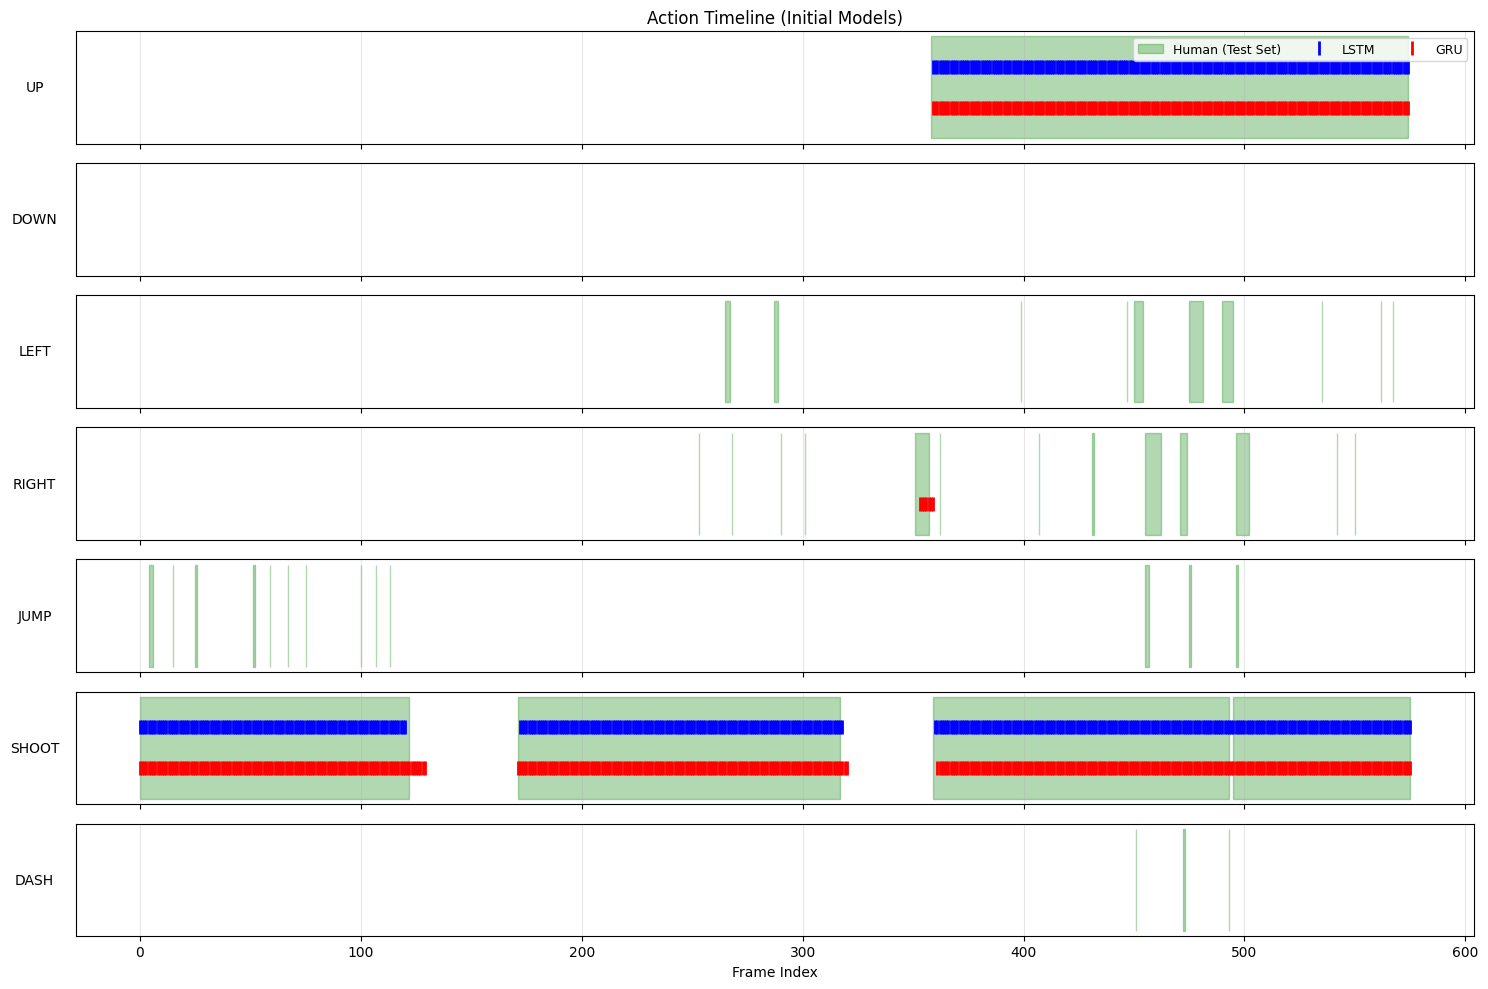

0

In [ ]:
# timeline visualization
start_f, end_f = 0, 580
y_true_slice = y_test_seq[start_f:end_f]

# Predict (Re-running inference for visualization subset)
y_pred_lstm = (model_lstm.predict(X_test_seq[start_f:end_f], verbose=0) > 0.5).astype(int)
y_pred_gru = (model_gru.predict(X_test_seq[start_f:end_f], verbose=0) > 0.5).astype(int)

# Plot
fig, axes = plt.subplots(NUM_ACTIONS, 1, figsize=(15, 10), sharex=True)
time_steps = np.arange(start_f, end_f)

for i, action in enumerate(ACTION_ORDER):
    ax = axes[i]
    # Human input
    ax.fill_between(time_steps, 0, 1, where=y_true_slice[:, i]==1,
                    color='green', alpha=0.3, label='Human (Test Set)')

    # LSTM Predictions (Blue Ticks)
    lstm_ticks = time_steps[y_pred_lstm[:, i]==1]
    ax.plot(lstm_ticks, np.ones_like(lstm_ticks)*0.7, '|',
            color='blue', mew=2, ms=10, label='LSTM')

    # GRU Predictions (Red Ticks)
    gru_ticks = time_steps[y_pred_gru[:, i]==1]
    ax.plot(gru_ticks, np.ones_like(gru_ticks)*0.3, '|',
            color='red', mew=2, ms=10, label='GRU')

    ax.set_ylabel(action, rotation=0, labelpad=30, fontsize=10, va='center')
    ax.set_yticks([])
    ax.grid(True, axis='x', alpha=0.3)

    if i == 0:
        ax.legend(loc="upper right", ncol=3, fontsize=9)
        ax.set_title(f"Action Timeline (Initial Models)")

plt.xlabel("Frame Index")
plt.tight_layout()
plt.savefig(os.path.join(EXPERIMENT_DIR, "1_timeline_viz.png"))
plt.show()

# Final Cleanup
del encoder, model_lstm, model_gru, X_test_raw, X_test_latent, X_test_seq
backend.clear_session()
gc.collect()

## **5. Phase 2: Advanced Architecture (Focal Loss & Grid Search)**

### **5.1 Mathematical Optimization: Sigmoid Focal Loss**
To rectify the class imbalance observed in Phase 1, I replace standard Cross-Entropy with **Sigmoid Focal Loss**.

**Algorithm:**
Focal Loss introduces a modulating factor $(1 - p_t)^\gamma$ to the cross-entropy loss, where $p_t$ is the model's estimated probability for the true class.
*   **Effect:** If the model is confident in a prediction (e.g., predicting "No Jump" correctly), the modulating factor approaches 0, effectively down-weighting the loss contribution of that example.
*   **Result:** The gradient descent process is forced to focus on "hard" examples (minority classes like Jumps/Dashes) where the model's confidence is low.

I set $\gamma=2.0$ to heavily penalize ignorance of rare events.

In [ ]:
# helper functions
def sigmoid_focal_loss(gamma=2.0, alpha=0.25):
    """
    Implements Focal Loss (Lin et al.) to address severe class imbalance.
    Down-weights well-classified examples to focus training on hard negatives.
    """
    def loss_fn(y_true, y_pred):
        eps = 1e-7
        y_pred = tf.clip_by_value(y_pred, eps, 1.0 - eps)

        # Calculate p_t: probabilities for the ground truth class
        p_t = tf.where(tf.equal(y_true, 1.0), y_pred, 1 - y_pred)
        alpha_factor = tf.where(tf.equal(y_true, 1.0), alpha, 1.0 - alpha)

        # Modulating factor (1 - p_t)^gamma reduces loss contribution from easy examples
        modulating = tf.pow(1.0 - p_t, gamma)
        loss = -alpha_factor * modulating * tf.math.log(p_t)
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return loss_fn

def create_weighted_sequences(features, labels, seq_len, rare_actions={'JUMP', 'DASH'}, factor=6.0):
    """
    Generates sequences with sample weights to penalize errors on minority classes.
    """
    X_seq, y_seq, weights = [], [], []
    rare_indices = [ACTION_ORDER.index(a) for a in rare_actions]

    for i in range(seq_len, len(features)):
        X_seq.append(features[i-seq_len:i])
        y_seq.append(labels[i])

        # Apply higher weight if any rare action occurs within the window context
        is_rare = np.any(labels[i-seq_len:i+1][:, rare_indices] > 0.5)
        weights.append(factor if is_rare else 1.0)

    return np.array(X_seq), np.array(y_seq), np.array(weights)

def build_advanced_ae(latent_dim):
    """
    Builds a Convolutional Autoencoder to learn a compressed latent representation of frames.
    Returns both the full AE (for training) and the Encoder (for feature extraction).
    """

    inp = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))

    # Encoder
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(inp)
    x = layers.MaxPool2D(2, padding='same')(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.MaxPool2D(2, padding='same')(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.MaxPool2D(2, padding='same')(x)

    flat = layers.Flatten()(x)
    z = layers.Dense(latent_dim, activation='relu', name='latent')(flat)

    # Decoder
    x = layers.Dense((IMG_HEIGHT//8)*(IMG_WIDTH//8)*128, activation='relu')(z)
    x = layers.Reshape((IMG_HEIGHT//8, IMG_WIDTH//8, 128))(x)
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2DTranspose(64, 3, padding='same', activation='relu')(x)
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu')(x)
    x = layers.UpSampling2D(2)(x)
    out = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)

    return models.Model(inp, out), models.Model(inp, z)


### **5.2 Architecture Grid Search**
I conduct a grid search to optimize two critical architectural hyperparameters:
1.  **Latent Space Dimension ($z$):** I test sizes $[128, 256, 512, 1024]$.
    *   *Hypothesis:* Too small (128) will blur small projectiles. Too large (1024) will lead to overfitting on background noise.
2.  **Recurrent Cell Type:** I compare LSTM vs. GRU.
    *   *Hypothesis:* The GRU's simpler gating mechanism (merged update gate) may generalize better on this limited dataset compared to the LSTM's complex three-gate structure.

**Evaluation Metric:**
I utilize a **Composite F1-Score**, averaging the F1 scores of the three critical mechanics: `JUMP`, `SHOOT`, and `DASH`. This penalizes models that maximize accuracy by being passive.

In [ ]:
LATENT_DIMS = [128, 256, 512, 1024]
results_log = []

# Indices for scoring: JUMP=4, SHOOT=5, DASH=6
IDX_JUMP, IDX_SHOOT, IDX_DASH = 4, 5, 6

for dim in LATENT_DIMS:
    print(f"\n Training Latent Dimension {dim}")

    # Train AE
    ae, enc = build_advanced_ae(dim)
    ae.compile(optimizer='adam', loss='mse')

    cb = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
    ae.fit(X_train, X_train, validation_data=(X_val, X_val),
           epochs=8, batch_size=32, callbacks=cb, verbose=1)

    enc.save(os.path.join(EXPERIMENT_DIR, f"2_encoder_{dim}.keras"))

    # Extract Features
    X_tr_lat = enc.predict(X_train, batch_size=64, verbose=1)
    X_val_lat = enc.predict(X_val, batch_size=64, verbose=1)

    # Weighted Sequences
    X_tr_seq, y_tr_seq, w_tr = create_weighted_sequences(X_tr_lat, y_train, SEQUENCE_LENGTH)
    X_val_seq, y_val_seq, w_val = create_weighted_sequences(X_val_lat, y_val, SEQUENCE_LENGTH)

    # Train Heads
    for rnn_type in ["LSTM", "GRU"]:
        model_name = f"2_{rnn_type.lower()}_{dim}.keras"
        print(f"   -> Training {rnn_type} (Focal Loss)...")

        inp = layers.Input(shape=(SEQUENCE_LENGTH, dim))
        if rnn_type == "LSTM":
            x = layers.LSTM(128, return_sequences=True)(inp)
            x = layers.Dropout(0.3)(x)
            x = layers.LSTM(64)(x)
        else:
            x = layers.GRU(128, return_sequences=True)(inp)
            x = layers.Dropout(0.3)(x)
            x = layers.GRU(64)(x)

        out = layers.Dense(NUM_ACTIONS, activation='sigmoid')(x)
        model = models.Model(inp, out)

        model.compile(optimizer=keras.optimizers.Adam(1e-3),
                      loss=sigmoid_focal_loss(),
                      metrics=[keras.metrics.BinaryAccuracy()])

        model.fit(X_tr_seq, y_tr_seq, sample_weight=w_tr,
                  validation_data=(X_val_seq, y_val_seq, w_val),
                  epochs=20, batch_size=32, verbose=1, callbacks=cb)

        model.save(os.path.join(EXPERIMENT_DIR, model_name))

        # get y_pred for evaluation
        y_pred = (model.predict(X_val_seq, verbose=0) > 0.5).astype(int)

        # Calculate F1 Scores per class
        f1_per_class = f1_score(y_val_seq, y_pred, average=None, zero_division=0)

        f1_jump = f1_per_class[IDX_JUMP]
        f1_shoot = f1_per_class[IDX_SHOOT]
        f1_dash = f1_per_class[IDX_DASH]

        # Composite Score: Average F1 of Critical Actions
        composite_score = (f1_jump + f1_shoot + f1_dash) / 3.0

        print(f"      [Metrics] Jump F1: {f1_jump:.2f} | Shoot F1: {f1_shoot:.2f} | Dash F1: {f1_dash:.2f}")
        print(f"      [Score]   Composite: {composite_score:.4f}")

        results_log.append({
            'dim': dim,
            'type': rnn_type,
            'composite_score': composite_score,
            'f1_jump': f1_jump,
            'f1_shoot': f1_shoot,
            'f1_dash': f1_dash,
            'model_path': os.path.join(EXPERIMENT_DIR, model_name),
            'enc_path': os.path.join(EXPERIMENT_DIR, f"2_encoder_{dim}.keras")
        })

        del model
        gc.collect()

    # Cleanup Iteration
    del ae, enc, X_tr_lat, X_val_lat, X_tr_seq, X_val_seq
    backend.clear_session()
    gc.collect()

# Select the best model based on the Composite Score (Balance of Jump, Shoot, Dash)
best_run = max(results_log, key=lambda x: x['composite_score'])

print("\n" + "="*60)
print(f" BEST MODEL SELECTED: {best_run['type']} (Latent {best_run['dim']})")
print(f"   Composite Score: {best_run['composite_score']:.4f}")
print(f"   Breakdown: Jump F1={best_run['f1_jump']:.2f}, Shoot F1={best_run['f1_shoot']:.2f}, Dash F1={best_run['f1_dash']:.2f}")
print("="*60)


 Training Latent Dimension 128
Epoch 1/8
299/299 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - loss: 0.0207 - val_loss: 0.0084
Epoch 2/8
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0081 - val_loss: 0.0063
Epoch 3/8
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0065 - val_loss: 0.0058
Epoch 4/8
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0059 - val_loss: 0.0052
Epoch 5/8
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0055 - val_loss: 0.0059
Epoch 6/8
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0053 - val_loss: 0.0050
Epoch 7/8
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0050 - val_loss: 0.0048
Epoch 8/8
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0049 - val_loss: 0.0045
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
   -> Training LSTM (Focal Loss)...
Epoch 1/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - binary_accuracy: 0.9420 - loss: 0.2982 - val_binary_accuracy: 0.9773 - val_loss: 0.1413
Epoch 2/20
299/299 ━

## **6. Comparative Analysis**
I aggregate the results of the grid search to identify the optimal architecture. The visualizations below generate heatmaps for Precision, Recall, and F1-Score across all action classes. I am looking for a configuration that balances high Precision (avoiding random button mashing) with acceptable Recall on the survival mechanics (Jumping/Dashing).

ALL MODELS VISUALIZATION & EVALUATION
Top Model: GRU 512 (Score: 0.6733)


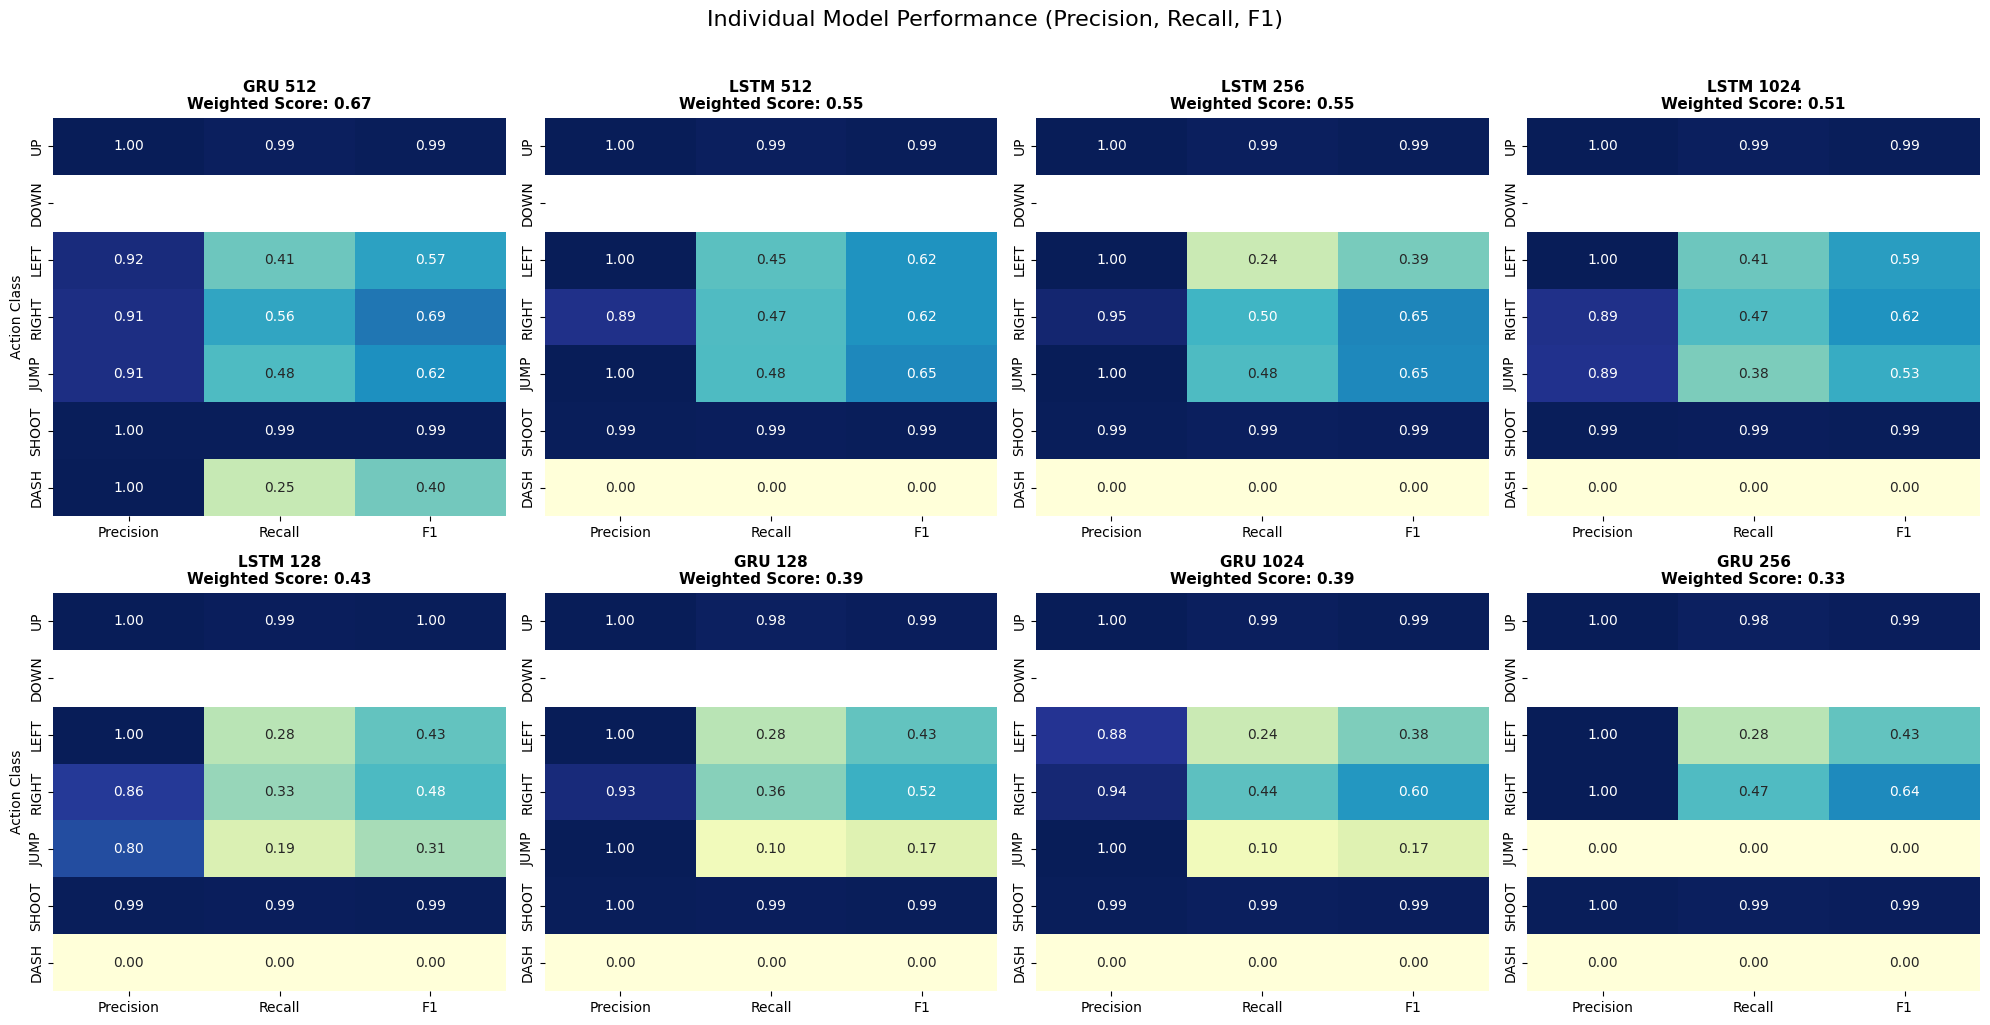

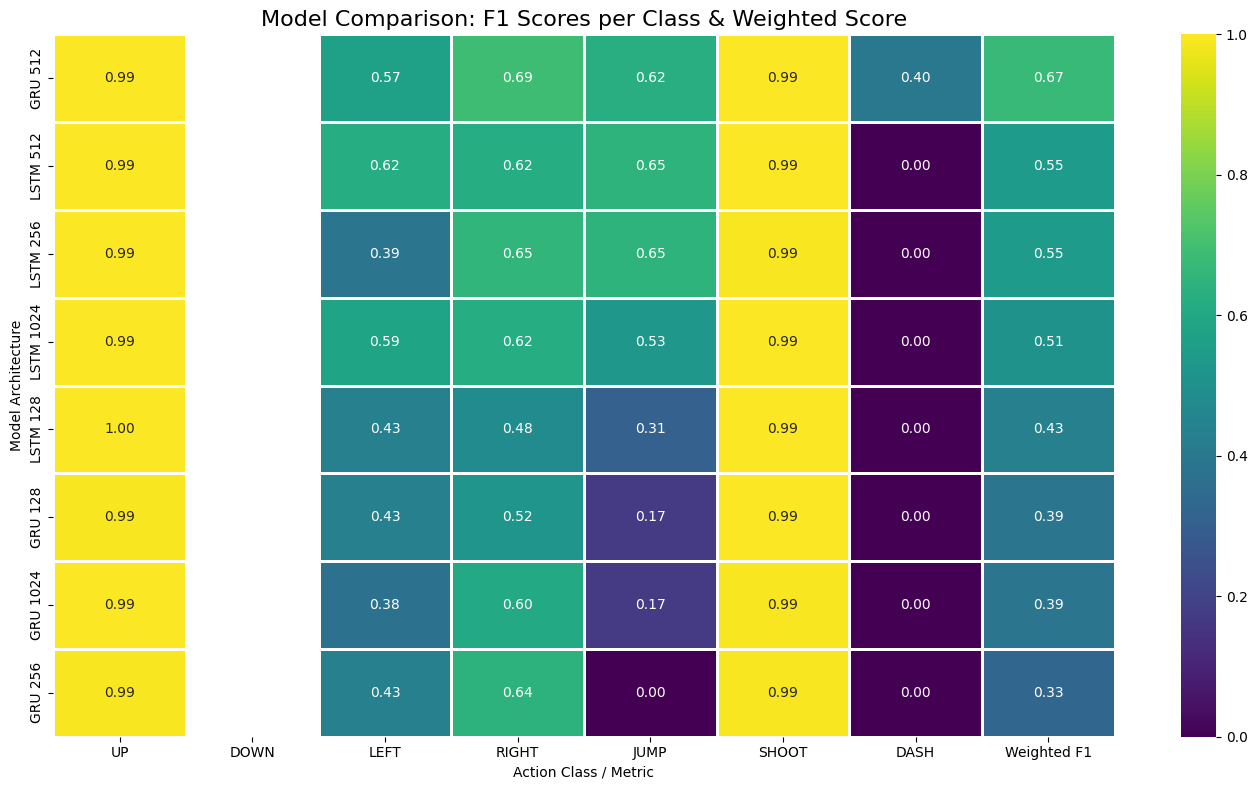

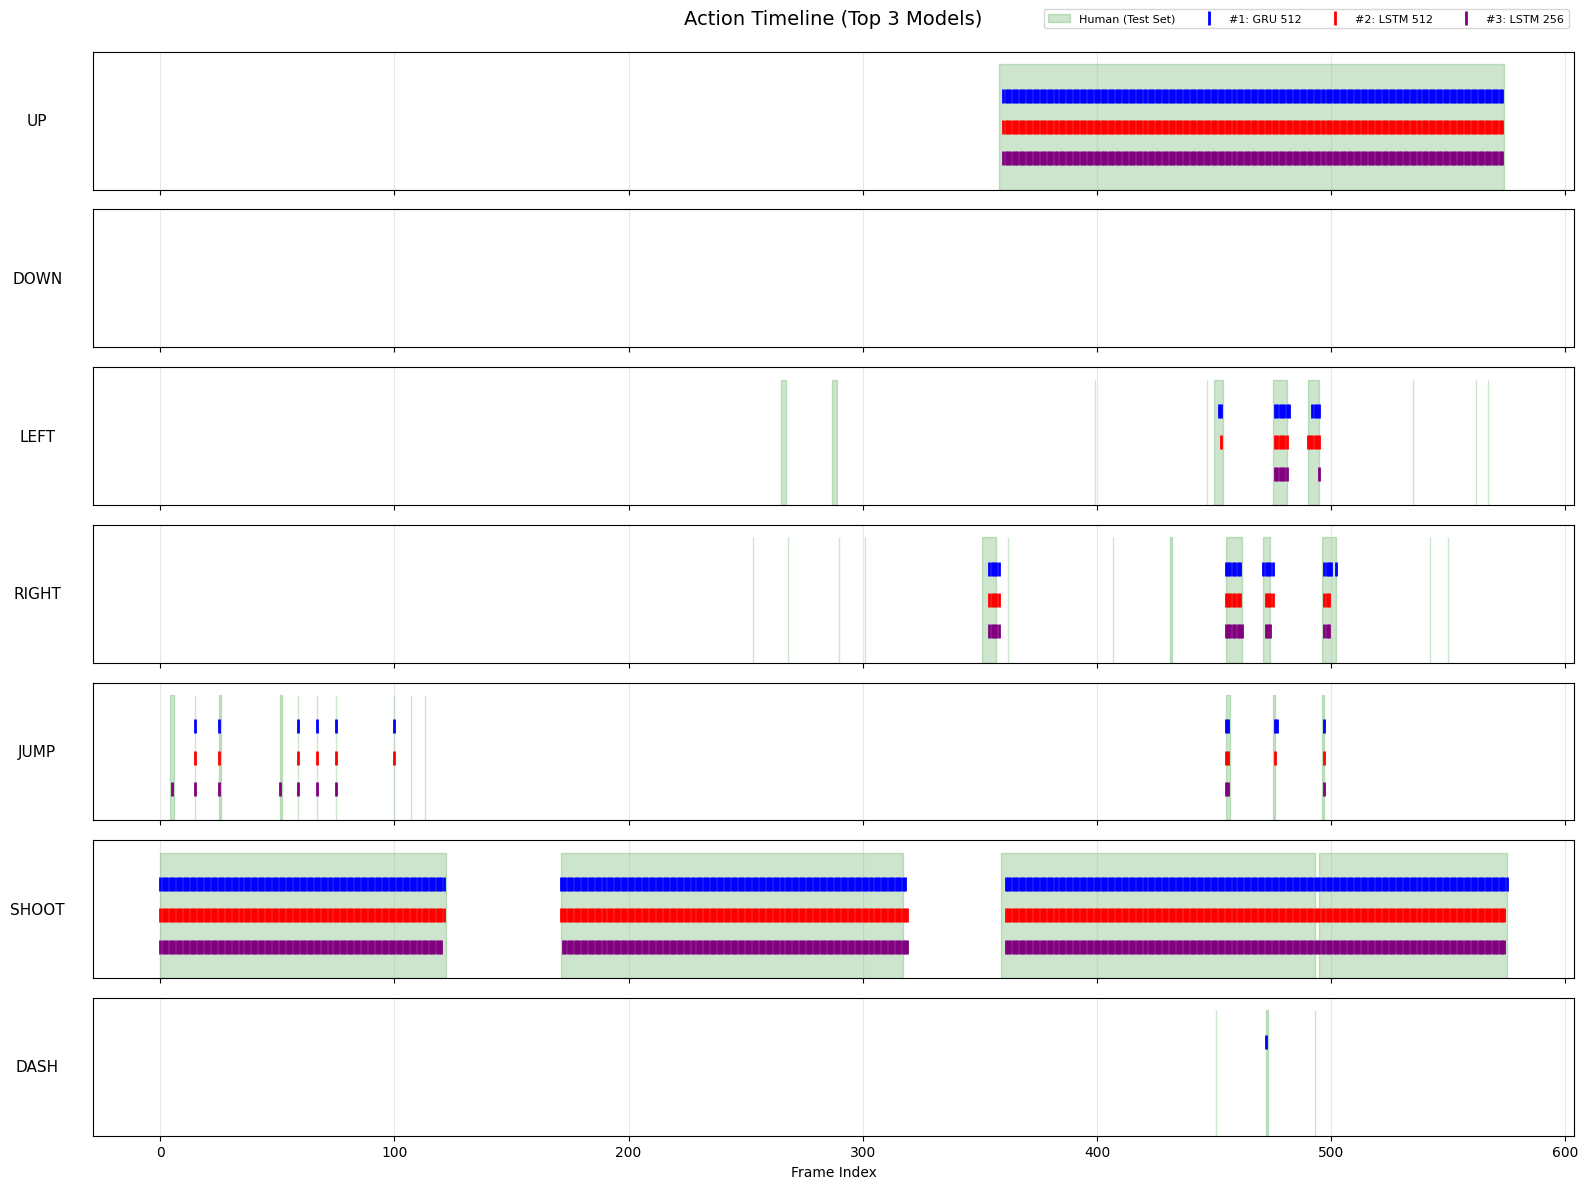

In [ ]:
print("ALL MODELS VISUALIZATION & EVALUATION")

# Container to store results for all models
all_model_results = []

# Load Test Data (Raw)
X_test_raw, y_test_raw = load_dataset([TEST_SESSION])

for dim in LATENT_DIMS:
    # Load Encoder for this dimension
    enc_path = os.path.join(EXPERIMENT_DIR, f"2_encoder_{dim}.keras")
    if not os.path.exists(enc_path):
        print(f"Skipping Dim {dim} (Encoder missing)")
        continue
    encoder = models.load_model(enc_path)

    # Create Sequences
    X_test_latent = encoder.predict(X_test_raw, batch_size=64, verbose=0)
    flat_dim = np.prod(X_test_latent.shape[1:])
    X_test_flat = X_test_latent.reshape(X_test_latent.shape[0], flat_dim)
    X_test_seq, y_test_seq = create_sequences_baseline(X_test_flat, y_test_raw, SEQUENCE_LENGTH)

    for rnn_type in ['LSTM', 'GRU']:
        model_path = os.path.join(EXPERIMENT_DIR, f"2_{rnn_type.lower()}_{dim}.keras")
        if not os.path.exists(model_path): continue

        # Load Model
        model = models.load_model(model_path, compile=False)

        # Predict
        y_pred_probs = model.predict(X_test_seq, verbose=0)
        y_pred = (y_pred_probs > 0.5).astype(int)

        # Calculate Metrics
        precision, recall, f1, support = precision_recall_fscore_support(y_test_seq, y_pred, average=None, zero_division=0)

        # Calculate Composite Score (Jump + Shoot + Dash) / 3
        composite_score = (f1[IDX_JUMP] + f1[IDX_SHOOT] + f1[IDX_DASH]) / 3.0

        # Store Data
        all_model_results.append({
            'name': f"{rnn_type} {dim}",
            'type': rnn_type,
            'dim': dim,
            'y_pred': y_pred,  # Store predictions for timeline
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'support': support,
            'composite_score': composite_score
        })

        del model
        backend.clear_session()
        gc.collect()

    del encoder, X_test_latent, X_test_flat, X_test_seq
    gc.collect()

# Sort models by Composite Score (Best first)
all_model_results.sort(key=lambda x: x['composite_score'], reverse=True)
top_3_models = all_model_results[:3]

print(f"Top Model: {top_3_models[0]['name']} (Score: {top_3_models[0]['composite_score']:.4f})")
num_models = len(all_model_results)
cols = 4
rows = (num_models + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))
axes = axes.flatten()

for i, res in enumerate(all_model_results):
    ax = axes[i]

    # Prepare DataFrame for Heatmap
    df_metrics = pd.DataFrame({
        "Precision": res['precision'],
        "Recall": res['recall'],
        "F1": res['f1']
    }, index=ACTION_ORDER)

    # Mask N/A values (Support == 0)
    mask = np.zeros_like(df_metrics)
    for idx, count in enumerate(res['support']):
        if count == 0: mask[idx, :] = 1  # Mask entire row if support is 0

    # Plot
    sns.heatmap(df_metrics, annot=True, fmt=".2f", cmap="YlGnBu",
                vmin=0, vmax=1, mask=mask.astype(bool), ax=ax, cbar=False)

    ax.set_title(f"{res['name']}\nWeighted Score: {res['composite_score']:.2f}", fontsize=11, fontweight='bold')
    if i % cols == 0: ax.set_ylabel("Action Class")

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle("Individual Model Performance (Precision, Recall, F1)", fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(EXPERIMENT_DIR, "viz1_individual_heatmaps.png"))
plt.show()

# Prepare Comparison Data
comp_data = []
for res in all_model_results:
    row = {}
    # Per Class F1
    for idx, action in enumerate(ACTION_ORDER):
        # If support is 0, set to NaN for visualization
        val = res['f1'][idx] if res['support'][idx] > 0 else np.nan
        row[f"{action}"] = val

    # Weighted F1
    row["Weighted F1"] = res['composite_score']
    comp_data.append(row)

df_comp = pd.DataFrame(comp_data, index=[r['name'] for r in all_model_results])

plt.figure(figsize=(14, 8))
# Create a custom mask for NaN values (N/A classes)
mask = df_comp.isna()

sns.heatmap(df_comp, annot=True, fmt=".2f", cmap="viridis",
            vmin=0, vmax=1, mask=mask, linewidths=1, linecolor='white')

plt.title("Model Comparison: F1 Scores per Class & Weighted Score", fontsize=16)
plt.ylabel("Model Architecture")
plt.xlabel("Action Class / Metric")
plt.tight_layout()
plt.savefig(os.path.join(EXPERIMENT_DIR, "viz2_comparison_heatmap.png"))
plt.show()

start_f, end_f = 0, 580
y_true_slice = y_test_seq[start_f:end_f]
time_steps = np.arange(start_f, end_f)

fig, axes = plt.subplots(NUM_ACTIONS, 1, figsize=(16, 12), sharex=True)

# Colors for the top 3 models
colors = ['blue', 'red', 'purple']
offsets = [0.75, 0.50, 0.25]

for i, action in enumerate(ACTION_ORDER):
    ax = axes[i]

    # 1. Plot Human Input
    ax.fill_between(time_steps, 0, 1, where=y_true_slice[:, i]==1,
                    color='green', alpha=0.2, label='Human (Test Set)')

    # 2. Plot Top 3 Models
    for rank, model_res in enumerate(top_3_models):
        pred_slice = model_res['y_pred'][start_f:end_f]
        ticks = time_steps[pred_slice[:, i] == 1]

        if len(ticks) > 0:
            ax.plot(ticks, np.ones_like(ticks) * offsets[rank], '|',
                    color=colors[rank], mew=2, ms=10,
                    label=f"#{rank+1}: {model_res['name']}")

    ax.set_ylabel(action, rotation=0, labelpad=40, fontsize=11, va='center')
    ax.set_yticks([])
    ax.set_ylim(0, 1.1)
    ax.grid(True, axis='x', alpha=0.3)

    # Legend only on the first plot
    if i == 0:
        ax.legend(loc="upper right", bbox_to_anchor=(1, 1.35), ncol=4, fontsize=8)
        ax.set_title(f"Action Timeline (Top 3 Models)", fontsize=14, pad=20)

plt.xlabel("Frame Index")
plt.tight_layout()
plt.savefig(os.path.join(EXPERIMENT_DIR, "viz3_top3_timeline.png"))
plt.show()

## **7. Best Model Validation (GRU-512)**
Based on the Composite Score, the **GRU with 512 Latent Dimensions** was selected as the optimal architecture.

BEST MODEL VISUALIZATION & EVALUATION


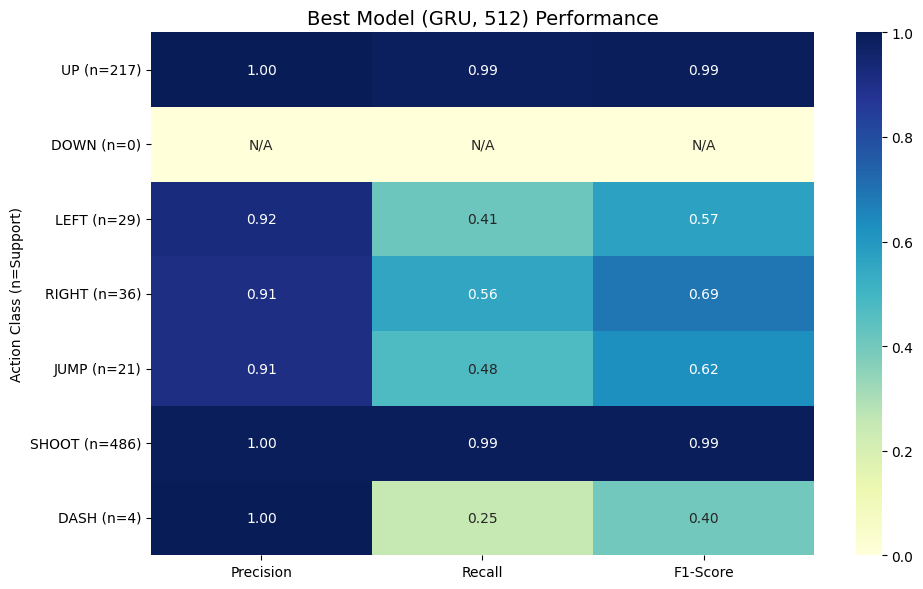

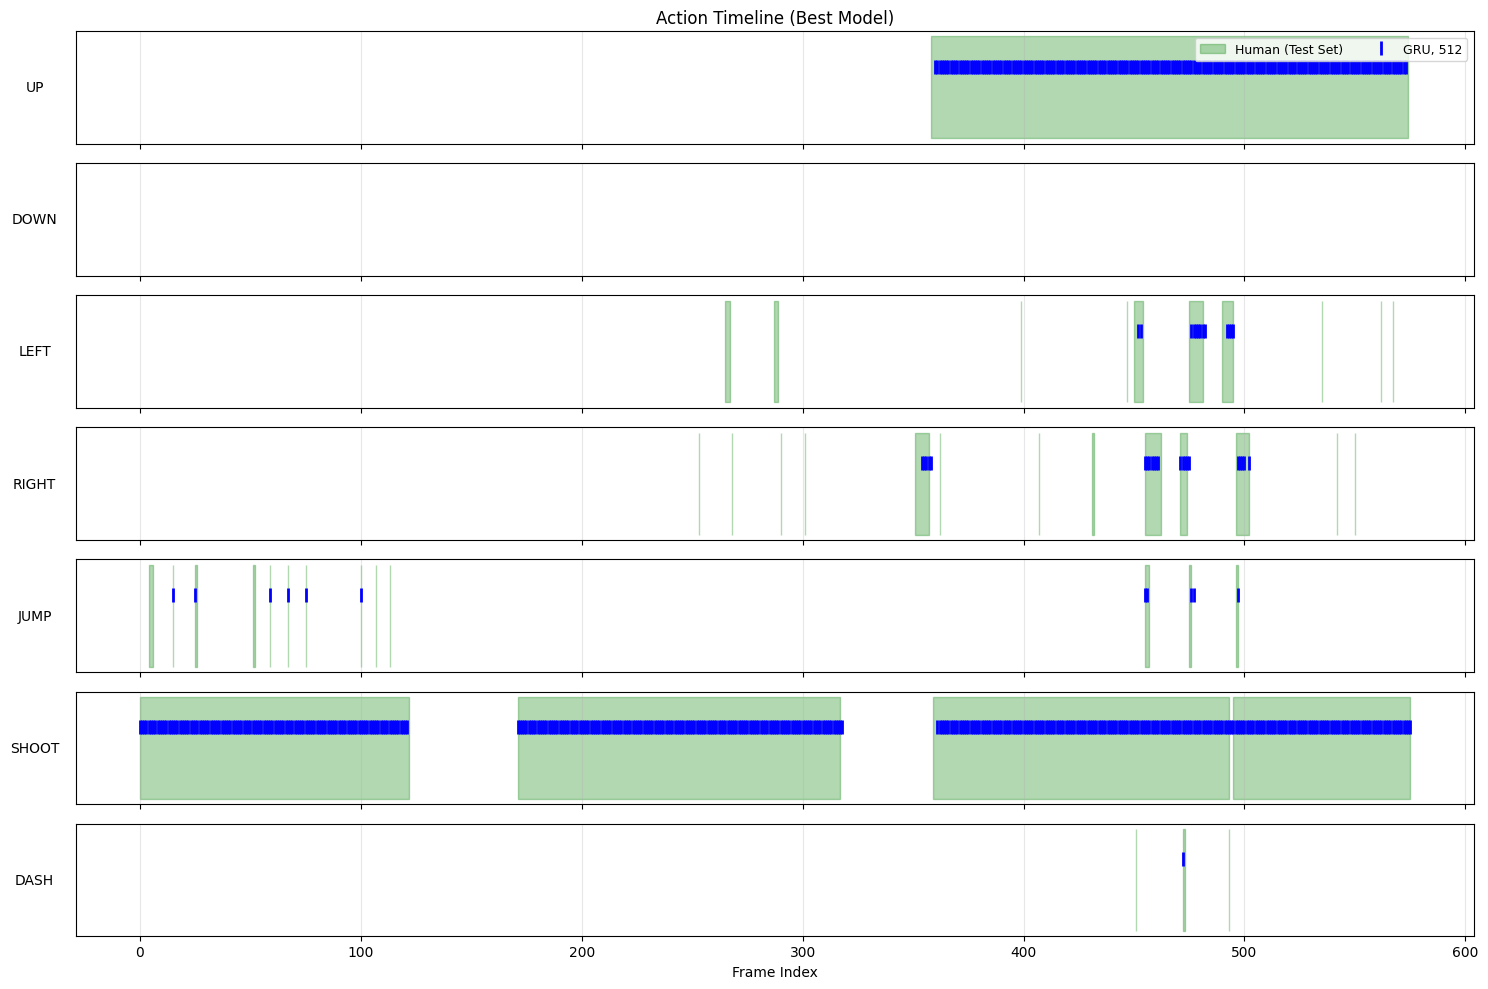

In [ ]:
print("BEST MODEL VISUALIZATION & EVALUATION")

best_run = {
    'type': 'GRU',
    'dim': 512,
    # Note: Filenames were saved in lowercase (e.g., '2_gru_512.keras')
    'enc_path': os.path.join(EXPERIMENT_DIR, "2_encoder_512.keras"),
    'model_path': os.path.join(EXPERIMENT_DIR, "2_gru_512.keras")
}

# Load Best Models
final_encoder = models.load_model(best_run['enc_path'])
final_model = models.load_model(best_run['model_path'], compile=False)

# Load Test Session
X_test_raw, y_test_raw = load_dataset([TEST_SESSION])

# Encode & Create Sequences
X_test_latent = final_encoder.predict(X_test_raw, batch_size=64, verbose=0)

# Flatten Latent Space
flat_dim = np.prod(X_test_latent.shape[1:])
X_test_flat = X_test_latent.reshape(X_test_latent.shape[0], flat_dim)

# Create Sequences
X_test_seq, y_test_seq = create_sequences_baseline(X_test_flat, y_test_raw, SEQUENCE_LENGTH)

# Generate Metrics (Single Model)
model_name = f"Best Model ({best_run['type']}, {best_run['dim']})"
df_final, annot_final, labels_final = get_model_metrics_viz(final_model)

# Plot Heatmaps
plt.figure(figsize=(10, 6))

# Final Model Heatmap
sns.heatmap(df_final, annot=annot_final, cmap="YlGnBu", vmin=0, vmax=1, fmt="")
plt.title(f"{model_name} Performance", fontsize=14)
plt.ylabel("Action Class (n=Support)")
plt.yticks(np.arange(len(labels_final)) + 0.5, labels_final, rotation=0)

plt.tight_layout()
plt.savefig(os.path.join(EXPERIMENT_DIR, "final_heatmap.png"))
plt.show()

# Timeline Visualization
start_f, end_f = 0, 580
y_true_slice = y_test_seq[start_f:end_f]

# Predict (Re-running inference for visualization subset)
y_pred_final = (final_model.predict(X_test_seq[start_f:end_f], verbose=0) > 0.5).astype(int)

# Plot
fig, axes = plt.subplots(NUM_ACTIONS, 1, figsize=(15, 10), sharex=True)
time_steps = np.arange(start_f, end_f)

for i, action in enumerate(ACTION_ORDER):
    ax = axes[i]
    # Human Predictions
    ax.fill_between(time_steps, 0, 1, where=y_true_slice[:, i]==1,
                    color='green', alpha=0.3, label='Human (Test Set)')

    # AI Predictions
    ai_ticks = time_steps[y_pred_final[:, i]==1]
    ax.plot(ai_ticks, np.ones_like(ai_ticks)*0.7, '|',
            color='blue', mew=2, ms=10, label=f'{best_run["type"]}, {best_run["dim"]}')

    ax.set_ylabel(action, rotation=0, labelpad=30, fontsize=10, va='center')
    ax.set_yticks([])
    ax.grid(True, axis='x', alpha=0.3)

    if i == 0:
        ax.legend(loc="upper right", ncol=3, fontsize=9)
        ax.set_title(f"Action Timeline (Best Model)")

plt.xlabel("Frame Index")
plt.tight_layout()
plt.savefig(os.path.join(EXPERIMENT_DIR, "final_timeline_viz.png"))
plt.show()

## **8. Video Overlay Analysis**

In [ ]:
# Paths
test_vid_path = os.path.join(BASE_PATH, f"{TEST_SESSION}.mp4")
test_evt_path = os.path.join(BASE_PATH, f"{TEST_SESSION}_events.jsonl")
test_frm_path = os.path.join(BASE_PATH, f"{TEST_SESSION}_frames.jsonl")

# Layout Configuration
SIDEBAR_WIDTH = 400
TIMELINE_HEIGHT = 140
TIMELINE_BG_COLOR = (20, 20, 20)
PLAYHEAD_COLOR = (255, 255, 255)
LABEL_AREA_WIDTH = 70

# Load Time and Human Inputs
with open(test_frm_path, 'r') as f:
    timestamps = [json.loads(line)['t'] for line in f]
_, events = parse_events(test_evt_path)
human_timeline = build_timeline(events, timestamps)

# Pre-calculate AI Predictions for the whole video
print("Pre-calculating AI predictions for timeline...")
cap = cv2.VideoCapture(test_vid_path)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

all_frames = []
while cap.isOpened():
    ret, frame = cap.read()
    if not ret: break
    small = cv2.resize(frame, (IMG_WIDTH, IMG_HEIGHT))
    gray = cv2.cvtColor(small, cv2.COLOR_BGR2GRAY).astype('float32') / 255.0
    all_frames.append(np.expand_dims(gray, axis=-1))
cap.release()

all_frames = np.array(all_frames)

# Encode & Predict
print("   Encoding and Predicting...")
all_latents = final_encoder.predict(all_frames, batch_size=64, verbose=0)
flat_dim = np.prod(all_latents.shape[1:])
all_latents_flat = all_latents.reshape(all_latents.shape[0], flat_dim)

X_seq, _ = create_sequences_baseline(all_latents_flat, np.zeros((len(all_latents_flat), NUM_ACTIONS)), SEQUENCE_LENGTH)
ai_probs = final_model.predict(X_seq, batch_size=64, verbose=0)
ai_binary = (ai_probs > 0.5).astype(int)

# Pad initial frames
padding = np.zeros((SEQUENCE_LENGTH, NUM_ACTIONS), dtype=int)
all_ai_preds = np.vstack((padding, ai_binary))

# BUILD STATIC TIMELINE BASE
TOTAL_WIDTH = width + SIDEBAR_WIDTH
timeline_base = np.full((TIMELINE_HEIGHT, TOTAL_WIDTH, 3), TIMELINE_BG_COLOR, dtype=np.uint8)

row_height = TIMELINE_HEIGHT // NUM_ACTIONS
# Calculate horizontal scale excluding the label area
timeline_draw_width = TOTAL_WIDTH - LABEL_AREA_WIDTH
scale_x = timeline_draw_width / total_frames

print("Generating static timeline background...")
for i, action in enumerate(ACTION_ORDER):
    y_start = i * row_height
    y_end = y_start + row_height

    # 1. Draw Row Label (Centered in the reserved Left Column)
    text_size = cv2.getTextSize(action, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)[0]
    text_y = y_start + (row_height + text_size[1]) // 2
    cv2.putText(timeline_base, action, (5, text_y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (150, 150, 150), 1)

    # 2. Draw Divider Line
    cv2.line(timeline_base, (0, y_end), (TOTAL_WIDTH, y_end), (40, 40, 40), 1)

    # 3. Draw Events
    # Define bar vertical size (leaving 2px padding for cleaner look)
    bar_pad = 2
    h_bar_top = y_start + bar_pad
    h_bar_btm = y_start + (row_height // 2) - 1

    a_bar_top = y_start + (row_height // 2) + 1
    a_bar_btm = y_end - bar_pad

    for f_idx in range(len(all_frames)):
        # Shift X start by LABEL_AREA_WIDTH
        x_start = LABEL_AREA_WIDTH + int(f_idx * scale_x)
        x_end = LABEL_AREA_WIDTH + int((f_idx + 1) * scale_x) + 1

        # Human (Green - Top Half)
        human_keys = human_timeline[f_idx]
        is_human_active = any(KEY_MAP.get(k) == action for k in human_keys)

        if is_human_active:
            cv2.rectangle(timeline_base, (x_start, h_bar_top), (x_end, h_bar_btm), (0, 150, 0), -1)

        # AI (Red - Bottom Half)
        if f_idx < len(all_ai_preds) and all_ai_preds[f_idx][i] == 1:
            cv2.rectangle(timeline_base, (x_start, a_bar_top), (x_end, a_bar_btm), (0, 0, 150), -1)

# VIDEO RENDERING
output_path = os.path.join(EXPERIMENT_DIR, "Final_Comparison_Timeline_Clean.mp4")
out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (TOTAL_WIDTH, height + TIMELINE_HEIGHT))
cap = cv2.VideoCapture(test_vid_path)

# Helper for sidebar circles
def draw_input_column(img, active_keys, header_text, col_x_start, color_active):
    cv2.putText(img, header_text, (col_x_start, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    for i, act in enumerate(ACTION_ORDER):
        center_y = 80 + (i * 35)
        c_fill = color_active if act in active_keys else (40, 40, 40)
        c_txt = (255, 255, 255) if act in active_keys else (100, 100, 100)
        cv2.circle(img, (col_x_start + 20, center_y), 8, c_fill, -1 if act in active_keys else 1)
        cv2.putText(img, act, (col_x_start + 45, center_y + 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, c_txt, 1)

print(f"Rendering to {output_path}...")
frame_idx = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret: break

    # Sidebar Logic
    curr_h_keys = {KEY_MAP[k] for k in human_timeline[frame_idx] if k in KEY_MAP and KEY_MAP[k] in ACTION_ORDER} if frame_idx < len(human_timeline) else set()
    curr_a_keys = {ACTION_ORDER[i] for i, p in enumerate(all_ai_preds[frame_idx]) if p == 1} if frame_idx < len(all_ai_preds) else set()

    # Draw Top Section
    sidebar = np.zeros((height, SIDEBAR_WIDTH, 3), dtype=np.uint8)
    draw_input_column(sidebar, curr_h_keys, "HUMAN", 20, (0, 255, 0))
    draw_input_column(sidebar, curr_a_keys, "AI MODEL", 200, (0, 0, 255))
    top_section = np.hstack((frame, sidebar))

    # Draw Bottom Section (Timeline)
    current_timeline = timeline_base.copy()

    # Calculate Playhead X (Shifted by label area)
    playhead_x = LABEL_AREA_WIDTH + int(frame_idx * scale_x)

    # Draw Playhead
    cv2.line(current_timeline, (playhead_x, 0), (playhead_x, TIMELINE_HEIGHT), PLAYHEAD_COLOR, 1)

    # Frame Counter Text
    txt_x = min(playhead_x + 5, TOTAL_WIDTH - 60)
    cv2.putText(current_timeline, f"{frame_idx}", (txt_x, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (200, 200, 200), 1)

    out.write(np.vstack((top_section, current_timeline)))

    if frame_idx % 100 == 0: print(f"      Processed {frame_idx}/{total_frames} frames...", end='\r')
    frame_idx += 1

cap.release()
out.release()
print("\nVideo Saved.")
backend.clear_session()
gc.collect()

Pre-calculating AI predictions for timeline...
   Encoding and Predicting...
Generating static timeline background...
Rendering to /content/drive/My Drive/Dain_CS156_Assignment2/Results/Final_Comparison_Timeline_Clean.mp4...

Video Saved.


0

# Appendix B: EDA


DATASET BALANCE ANALYSIS: Train
Total Frames Analyzed: 14791
----------------------------------------
Action  Frame_Count Percentage
 SHOOT         8254     55.80%
    UP         3980     26.91%
 RIGHT          875      5.92%
  LEFT          869      5.88%
  JUMP          434      2.93%
  DASH          105      0.71%
  DOWN           60      0.41%
----------------------------------------


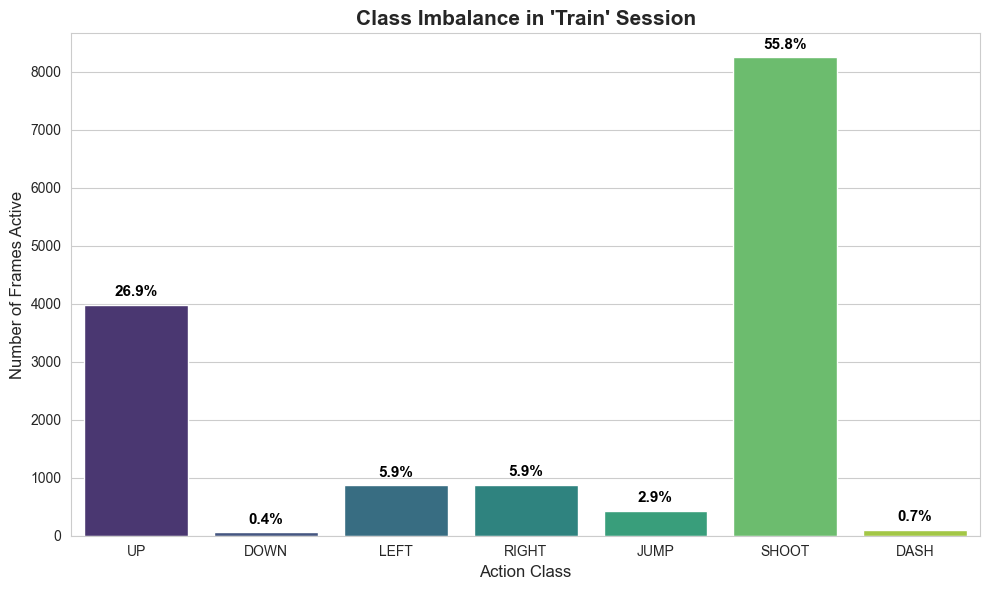

In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

DATA_DIR = Path("../data/sessions") 
SESSION_NAME = "Train"

# Key Mappings
KEY_MAP = {
    'Key.up': 'UP', 'Key.down': 'DOWN', 'Key.left': 'LEFT', 'Key.right': 'RIGHT', 
    'Key.space': 'JUMP', 'f': 'SHOOT', 'd': 'DASH'
}
ACTION_ORDER = ['UP', 'DOWN', 'LEFT', 'RIGHT', 'JUMP', 'SHOOT', 'DASH']

def analyze_keystroke_balance():
    # 1. Define Paths
    event_path = DATA_DIR / f"{SESSION_NAME}_events.jsonl"
    frame_path = DATA_DIR / f"{SESSION_NAME}_frames.jsonl"

    # 2. Load Events (Key Presses)
    events = []
    with open(event_path, 'r') as f:
        for line in f:
            try:
                d = json.loads(line)
                if d.get('event') in ['keydown', 'keyup']:
                    k = d.get('key').strip("'").strip('"')
                    if k in KEY_MAP: 
                        events.append((d['t'], k, d['event']))
            except: continue
    events.sort(key=lambda x: x[0]) # Sort by time

    # 3. Load Frame Timestamps
    with open(frame_path, 'r') as f:
        frame_timestamps = [json.loads(line)['t'] for line in f]

    # 4. Replay History to Count Active Frames
    # We iterate through frames and update key state incrementally
    active_keys = set()
    event_idx = 0
    num_events = len(events)
    
    # Dictionary to store how many frames each action was active
    action_counts = {action: 0 for action in ACTION_ORDER}
    total_frames = 0
    
    for t in frame_timestamps:
        # Update key state up to current frame time
        while event_idx < num_events and events[event_idx][0] <= t:
            _, key, etype = events[event_idx]
            if etype == 'keydown':
                active_keys.add(key)
            elif etype == 'keyup':
                active_keys.discard(key)
            event_idx += 1
            
        # Record state for this frame
        for k in active_keys:
            if k in KEY_MAP:
                action_name = KEY_MAP[k]
                action_counts[action_name] += 1
        
        total_frames += 1

    # 5. Process Statistics
    df = pd.DataFrame(list(action_counts.items()), columns=['Action', 'Frame_Count'])
    df['Percentage'] = (df['Frame_Count'] / total_frames) * 100

    # Print Stats Table
    print("\n" + "="*40)
    print(f"DATASET BALANCE ANALYSIS: {SESSION_NAME}")
    print("="*40)
    print(f"Total Frames Analyzed: {total_frames}")
    print("-" * 40)
    print(df.sort_values(by='Frame_Count', ascending=False).to_string(index=False, formatters={'Percentage': '{:.2f}%'.format}))
    print("-" * 40)

    # 6. Visualization
    plt.figure(figsize=(10, 6))
    
    # Create Bar Plot
    sns.set_style("whitegrid")
    ax = sns.barplot(x='Action', y='Frame_Count', data=df, order=ACTION_ORDER, palette='viridis', hue='Action', legend=False)
    
    plt.title(f"Class Imbalance in '{SESSION_NAME}' Session", fontsize=15, fontweight='bold')
    plt.ylabel("Number of Frames Active", fontsize=12)
    plt.xlabel("Action Class", fontsize=12)
    
    # Add percentage labels
    for i, p in enumerate(ax.patches):
        height = p.get_height()
        # Find the percentage for the current bar
        pct = df[df['Action'] == ACTION_ORDER[i]]['Percentage'].values[0]
        ax.text(p.get_x() + p.get_width() / 2., height + (total_frames * 0.01),
                f'{pct:.1f}%', ha="center", fontsize=11, fontweight='bold', color='black')

    plt.tight_layout()
    plt.show()


# Run the analysis
analyze_keystroke_balance()

## Appendix C: Custom Session Recorder Code

To ensure data integrity, I developed a custom Python application utilizing `tkinter` for the GUI, `mss` for high-speed screen capture, and `pynput` for non-blocking keyboard hooks.

[Full Source Code Repository](https://github.com/ddanakim0304/CS156-Assignment-2/tree/main/app)

### **C.1 Core Synchronization Logic (`session_recorder.py`)**
This module addresses the **Variable Frame Rate (VFR) Drift** problem described in Section 2.1.

**The Algorithm: Forced Constant Frame Rate**
Standard screen recording loops often use `time.sleep(1/fps)`. However, system latency ($\delta$) accumulates with every frame ($t_{sleep} + \delta$), causing the video to desynchronize from the wall-clock timestamps of the logs.

My solution:
1.  Calculate the exact UTC timestamp where the next frame *should* be (`next_frame_time`).
2.  Capture a frame.
3.  Compare `next_frame_time` to `time.time()` (current system time).
4.  **If the system is lagging** (Current Time > Next Frame Time), the loop writes the **same frame multiple times** to the video file and logs the specific timestamp for each duplicate. This ensures the video file duration matches real-time perfectly, even if the game stutters.

**Code Snippet:**
```python
with mss.mss() as sct:
    target_fps = 10.0
    frame_duration = 1.0 / target_fps
    
    # Schedule based on absolute UTC time
    next_frame_time = time.time()

    while not self._shutdown_event.is_set():
        # 1. Capture Frame
        try:
            img = sct.grab(self.region)
            img_np = np.array(img)
            frame_bgr = cv2.cvtColor(img_np, cv2.COLOR_BGRA2BGR)
        except Exception as e:
            print(f"Capture error: {e}")
            continue

        # 2. Sync Logic
        now = time.time()
        
        while next_frame_time < now:
            # Write video frame
            self._video_writer.write(frame_bgr)
            
            # RECORD EXACT MAPPING: Frame -> UTC Time
            frame_entry = {"t": next_frame_time}
            self._frame_file.write(json.dumps(frame_entry) + '\n')
            
            # Advance schedule
            next_frame_time += frame_duration
        
        # 3. Sleep
        # Only sleep if we are ahead of schedule
        time_to_sleep = next_frame_time - time.time()
        if time_to_sleep > 0:
            time.sleep(time_to_sleep)
```

### **C.2 Global Input Handling (`keyboard_listener.py`)**
This module uses `pynput` to hook keyboard events at the OS level, allowing the recorder to capture inputs even when the *Cuphead* window has focus.

**Key Logic:**
1. Converts platform-specific key codes (e.g., `Key.space`) into standardized string labels.
2. Maintains a set of `_pressed_keys` to prevent "key repeat" noise (holding a key down generating multiple events).
3. Implements a safety mechanism to pause listening while the user types the session name in the UI, preventing those keystrokes from leaking into the game logs.

### **C.3 UI and Thread Safety (`main.py`)**
The application runs the UI on the main thread (`tkinter`) and the recording logic on a separate background thread. To prevent race conditions or UI freezing, I implemented a **Message Queue** architecture.

**The Architecture:**
1.  Detects a hotkey (e.g., '1' to Stop). Puts a message into `ui_action_queue`.
2.  Polls the queue every 100ms. If a message is found, it updates the button state and triggers the `SessionRecorder`.

# AI Statement

- I utilized an LLM to brainstorm potential structures and outlines for my final report to ensure a logical flow of arguments.
- I used an AI assistant to help validate my analysis of the data visualizations and cross-reference my conclusions on model performance.
- I used an LLM to refine my writing by suggesting alternative phrasing to improve clarity and conciseness.
- I used an LLM to ensure a consistent academic tone and check for grammatical accuracy throughout the final report.